In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
qrm_rf.out0_in0_lo_cal()
qrm_rf.sequencer0.sideband_cal()



# Instruments

## qblox

In [181]:
from qblox_instruments import Cluster
from qblox_esr import qblox_esr
from qblox_esr.data_treatment import echo_data_treatment, auto_0th_ph_corr
from textwrap import dedent

# connect to QBLOX and QRM-RF on slot 6, run time ~5-10s
cluster = qblox_esr.connect2cluster("cluster-mm")  # warning can be safely ignored
qrm_rf = qblox_esr.connect2module(cluster, slot_nb=2)  # expected print: Status: OKAY, Flags: NONE, Slot flags: NONE

C:\ProgramData\miniconda3\envs\qcodes-res\lib\site-packages\qcodes\instrument\instrument_base.py:642: UserWarning: Changed cluster-mm to cluster_mm for instrument identifier
  warnings.warn(f"Changed {name} to {new_name} for instrument identifier")


cluster-mm connected at 192.168.0.2
QRM-RF connected
Status: OKAY, Flags: NONE, Slot flags: NONE


In [182]:
def get_data():
    # get data
    single_acq = qblox_esr.get_scope_acq_0(qrm_rf, "single", timeout=1000)
    
    data_i = np.array(single_acq["single"]["acquisition"]["scope"]["path0"]["data"])
    data_q = np.array(single_acq["single"]["acquisition"]["scope"]["path1"]["data"])

    return data_i + 1j*data_q

def get_data_int():
    # get data
    single_acq = qblox_esr.get_scope_acq_0(qrm_rf, "single", timeout=1000)
    
    data_i = np.array(single_acq["single"]['acquisition']['bins']['integration']['path0'])
    data_q = np.array(single_acq["single"]['acquisition']['bins']['integration']['path1'])

    return data_i + 1j*data_q

In [4]:
# TODO calibration funtions here

## VNA/SPEC switch

In [5]:
from res_drivers.Tenma2535 import Tenma722535  # TODO: put in res_drivers or 

def VNA_mode():
    tenma.set_voltage(12)

def SPEC_mode():
    tenma.set_voltage(0)

tenma = Tenma722535('COM3')  # switch power supply
print('Connected to Tenma')
tenma.set_voltage(0)
tenma.set_output(True)

Connected to Tenma


In [7]:
SPEC_mode()

## VNA

In [185]:
from res_sweep import measure, process, fit
from res_drivers.CobaltC2209 import CobaltC2209

ip = '127.0.0.1';
vna = CobaltC2209('VNA','TCPIP0::'+ip+'::5025::SOCKET')

Connected to: CMT C2209 (serial:18036105, firmware:25.3.3/2) in 0.06s


## field

In [8]:
from qcodes.instrument_drivers.american_magnetics import AMIModel430, AMIModel4303D

# connect to 3 magnet coils
# NB: increased timeout to avoid timeout error (was at 5s)
# could be fixed by new driver which automatically retries getting the value
# to see that value, use print(ix.get('timeout'))  # Explicit getter
ix = AMIModel430("x", address="TCPIP0::169.254.199.2::7180::SOCKET", timeout=10);
iy = AMIModel430("y", address="TCPIP0::169.254.199.1::7180::SOCKET", timeout=10);
iz = AMIModel430("z", address="TCPIP0::169.254.199.0::7180::SOCKET", timeout=10);

field_limit = [lambda x, y, z: x == 0 and y == 0 and z < 3,
               lambda x, y, z: np.linalg.norm([x, y, z]) < 3]
i3d = AMIModel4303D('AMI430_3D', ix, iy, iz,
                    field_limit = field_limit)

Connected to: AMERICAN MAGNETICS INC. 430 (serial:170059, firmware:2.58) in 0.92s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:170060, firmware:2.58) in 1.12s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:170061, firmware:2.58) in 1.27s


In [9]:
magnet = (ix, iy, iz, i3d)

In [10]:
measure.get_magnetic_field(magnet, magnet_type="AM1430")

np.float64(0.006597726881282674)

In [12]:
for i in range(5):
    print(measure.get_magnetic_field(magnet, magnet_type="AM1430"))
    time.sleep(5)

9.857847160511264
9.86140009734926
9.858795122123189
9.856663750478656
9.856433259044572


In [13]:
measure.get_magnetic_field(magnet, magnet_type="AM1430")

np.float64(9.860732064608591)

In [172]:
theta = 90-1.787 #x-axis
phi = 0.084
magnet_options = {"phi": phi, "theta": theta, "step":0.8}
_ = measure.set_magnetic_field(magnet, 47, magnet_type="AM1430", sleep_time=2, options=magnet_options)

Starting at field 46.80mT
Setting field to 47.00mT


# Resonator

In [183]:
VNA_mode()

S21 trace recorded in 5s, now displayed on VNA.



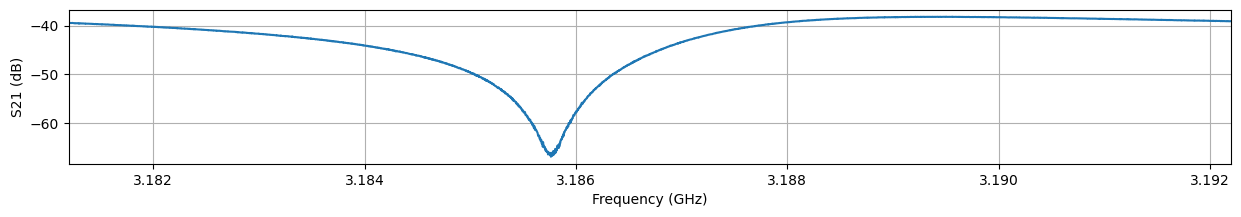

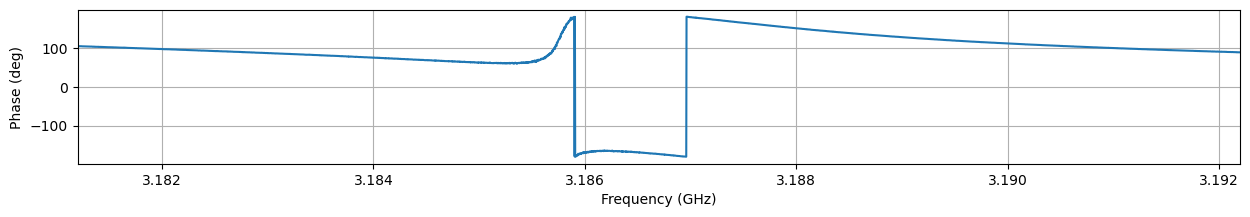

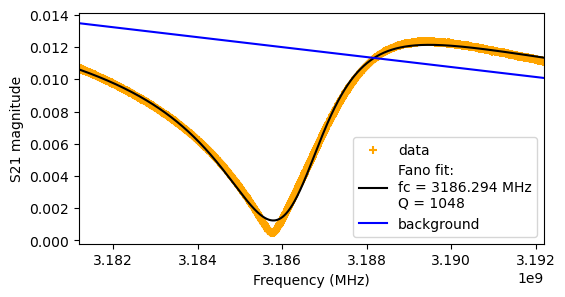

fc = 3186.294±0.003 MHz
Q = 1048±2
Linewidth = 3.039±0.007 MHz
R2 = 99.69%
Suggested guess values for next fit (values of current fit):
fc0=3.186294e+09, sigma0=3.04e+06, amp0=1.08e-02, q0=3.53e-01



In [186]:
f_centre = 3.1867e+09  # Hz
span = 5.5e6
sweep = [f_centre-span, f_centre+span]  
f_pts = 4000

mag, ph, metadata, filename = measure.VNA_sweep(vna, sweep[0], sweep[1], f_pts, bandwidth=1000, power=-10,
                                                elec_delay=73e-9, coeff='S21', plot=True, save=False,
                                                folder='data', filename=None, comments=None)

freq = np.linspace(sweep[0], sweep[1], f_pts)
fc, Ql, fit_res = fit.fit_Fano(freq, mag, fcrop=None, background=True,
                               fc0="min", sigma0=2e6, amp0=0.1, q0=0,
                               plot=True, verbose=True)

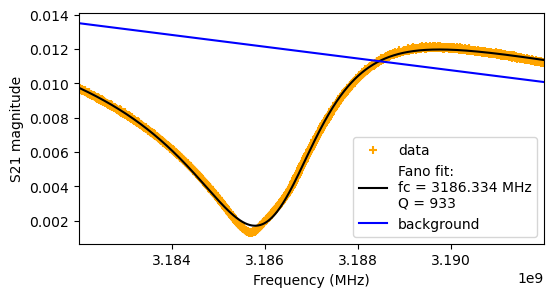

fc = 3186.334±0.003 MHz
Q = 933±2
Linewidth = 3.415±0.006 MHz
R2 = 99.87%
Suggested guess values for next fit (values of current fit):
fc0=3.186334e+09, sigma0=3.42e+06, amp0=1.05e-02, q0=3.53e-01



In [96]:
fc, Ql, fit_res = fit.fit_Fano(freq, mag, fcrop=[3.182e9,3.192e9], background=True,
                               fc0="min", sigma0=2e6, amp0=0.1, q0=0,
                               plot=True, verbose=True)

# Spectrometer

In [169]:
SPEC_mode()

## ringdown

In [152]:
def setup_hahnecho(amp, len_pi_over_2, len_pi, tau, rec_del, avg_nb=1, steps=None, ctp=None, dummy_nb=0, acq_pos=-4000):

    len_pi_over_2 = int(len_pi_over_2/2)
    
    waveforms = {
        "block11": {"data": [float(amp) for i in range(0, len_pi_over_2)], "index": 4},
    }

    acquisitions = {
        "single": {"num_bins": 1, "index": 0},
    }

    prog = dedent(f"""
    set_mrk(t1t2t3t4=0110)  # close internal qblox switch output
    upd_param 200
    play      4,4,{len_pi_over_2}   # play excitation waveform and wait its duration
    play      4,4,{len_pi_over_2}   # play excitation waveform and wait its duration
    wait      {tau}
    play      4,4,{len_pi_over_2}
    play      4,4,{len_pi_over_2}
    play      4,4,{len_pi_over_2}
    play      4,4,{len_pi_over_2}
    wait      100
    set_mrk(t1t2t3t4=0100)  # open switch output
    upd_param 8
    wait      {tau+acq_pos+150-8-100}
    acquire   0,0,4
    wait      {rec_del-acq_pos-150}
    """).lstrip('\n')
    
    seq_prog = qblox_esr.simple2real_Q1ASM(
                                prog, avg_nb=avg_nb, shot_nb=1, dummy_nb=dummy_nb,
                                steps=steps, ctp=ctp, twt_triggers=False)

    sequence = {
        "waveforms": waveforms,
        "weights": {},
        "acquisitions": acquisitions,
        "program": seq_prog,
    }

    return sequence


def acquire_int(npts=1000, tres=300):
    
    assert tres >= 300, 'tres of acquire_int should be >300ns.'
    
    prog = dedent(f"""
    for R44 in 0,1,{npts-1}
        acquire 0,R44,{tres}
    end
    """).lstrip('\n') # lstrip gets rid of leading character

    return prog.rstrip()


def setup_hahnecho2(amp, len_pi_over_2, len_pi, tau, rec_del, avg_nb=1, steps=None, ctp=None, dummy_nb=0, acq_pos=-4000, acq_npts=1000, acq_tres=300):

    len_pi_over_2 = int(len_pi_over_2/2)
    
    waveforms = {
        "block11": {"data": [float(amp) for i in range(0, len_pi_over_2)], "index": 4},
    }

    acquisitions = {
        "single": {"num_bins": acq_npts, "index": 0},
    }

    prog = dedent(f"""
    set_mrk(t1t2t3t4=0110)  # close internal qblox switch output
    upd_param 200
    play      4,4,{len_pi_over_2}   # play excitation waveform and wait its duration
    play      4,4,{len_pi_over_2}   # play excitation waveform and wait its duration
    wait      {tau}
    play      4,4,{len_pi_over_2}
    play      4,4,{len_pi_over_2}
    play      4,4,{len_pi_over_2}
    play      4,4,{len_pi_over_2}
    wait      100
    set_mrk(t1t2t3t4=0100)  # open switch output
    upd_param 8
    wait      {tau+acq_pos+150-8-100}
    {acquire_int(npts=acq_npts, tres=acq_tres)}  # 300us acquisition
    wait      {rec_del-acq_pos-150-acq_npts*acq_tres}
    """).lstrip('\n')
    
    seq_prog = qblox_esr.simple2real_Q1ASM(
                                prog, avg_nb=avg_nb, shot_nb=1, dummy_nb=dummy_nb,
                                steps=steps, ctp=ctp, twt_triggers=False)

    sequence = {
        "waveforms": waveforms,
        "weights": {},
        "acquisitions": acquisitions,
        "program": seq_prog,
    }

    return sequence

In [153]:
def setup_ringdown(amp, len_pi_over_2, len_pi, tau, rec_del, avg_nb=1, acq_pos=0, steps=None, ctp=None, dummy_nb=0):

    waveforms = {
        "block01": {"data": [float(amp) for i in range(0, len_pi_over_2)], "index": 2},
        "block02": {"data": [float(amp) for i in range(0, len_pi)], "index": 3},
        "block11": {"data": [float(amp) for i in range(0, len_pi_over_2)], "index": 4},
        "block12": {"data": [float(amp) for i in range(0, len_pi)], "index": 5},
    }

    acquisitions = {
        "single": {"num_bins": 1, "index": 0},
    }

    prog = dedent(f"""
    wait       200
    acquire   0,0,4
    set_mrk(t1t2t3t4=1100)  # on QRM-RF, t1t2t3t4=O1I1M1M2 # set_mrk   0011
    upd_param 400
    play      4,2,{len_pi_over_2}   # play excitation waveform and wait its duration
    wait      {tau}
    play      5,3,{len_pi} # play refocusing waveform and wait its duration
    wait      {tau}
    wait      {rec_del}
    """).lstrip('\n')

    seq_prog = qblox_esr.simple2real_Q1ASM(
                                prog, avg_nb=avg_nb, shot_nb=1, dummy_nb=dummy_nb,
                                steps=steps, ctp=ctp, twt_triggers=False)

    sequence = {
        "waveforms": waveforms,
        "weights": {},
        "acquisitions": acquisitions,
        "program": seq_prog,
    }

    return sequence

## Qblox Sequence

In [175]:
SPEC_mode()

In [85]:
freq_pulse = fc+0e6# 3.1e9 # frequency at which you're pulsing (Hz)
nco_f = 100e6 # Numerically Controlled Oscillator frequency (Hz)

In [86]:
amp = 1
len_pi_over_2 = int(2e3)
len_pi = 2*len_pi_over_2
tau = int(4e3)
rec_del = int(1e9)
avg_nb = 4
dummy_nb = 0
steps=None
ctp=None

In [87]:
sequence = setup_ringdown(amp, len_pi_over_2, len_pi, tau, rec_del, avg_nb=avg_nb, steps=None, ctp=None, dummy_nb=dummy_nb)
qblox_esr.qrm_rf_awg(qrm_rf, lo_freq=freq_pulse-nco_f, nco_freq=nco_f, in0_att=0, out0_att=10)
qrm_rf.sequencer0.nco_prop_delay_comp_en(True)

qblox_esr.config_acq(qrm_rf, integ_len=20000)
qrm_rf.sequencer0.sequence(sequence)

In [88]:
qrm_rf.arm_sequencer(0)
qrm_rf.start_sequencer()
data = get_data()

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


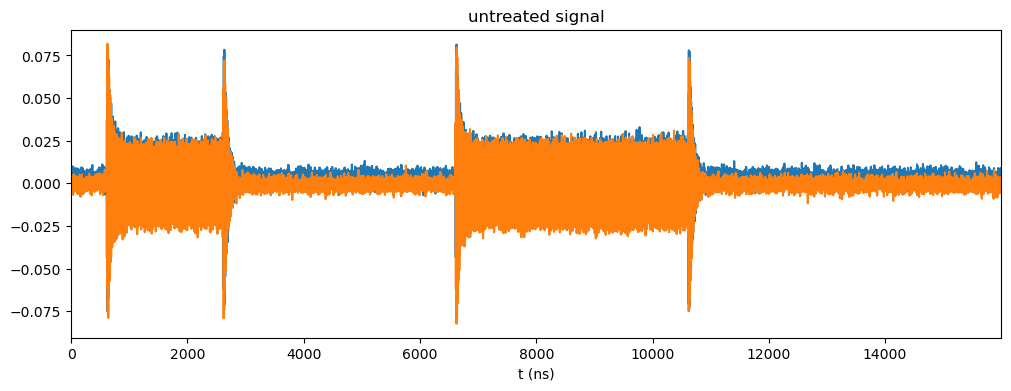

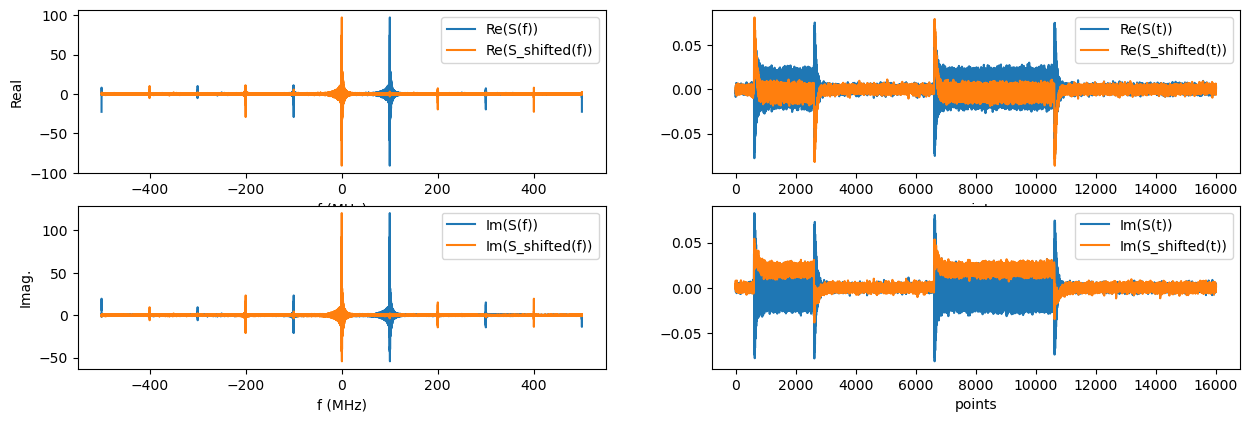

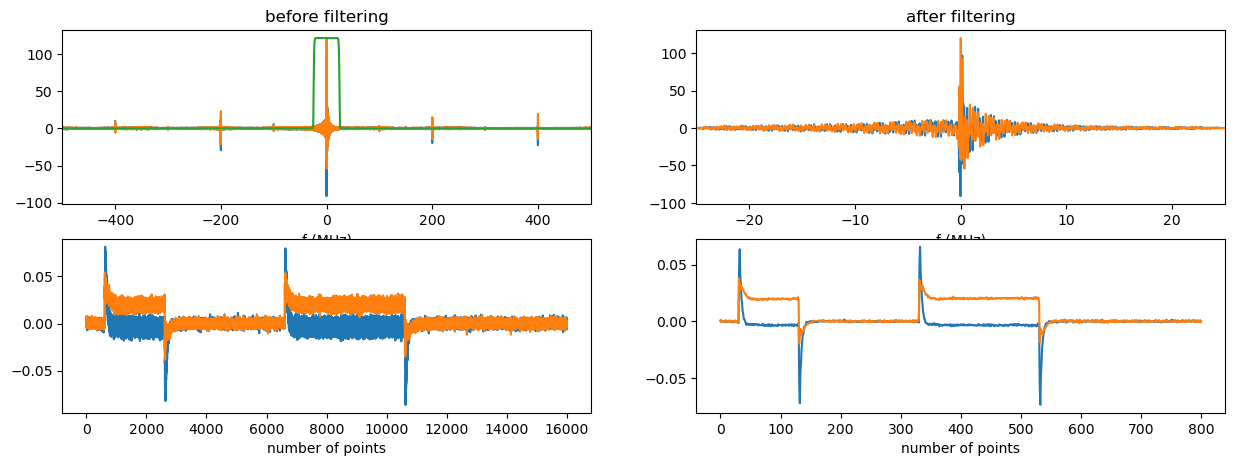

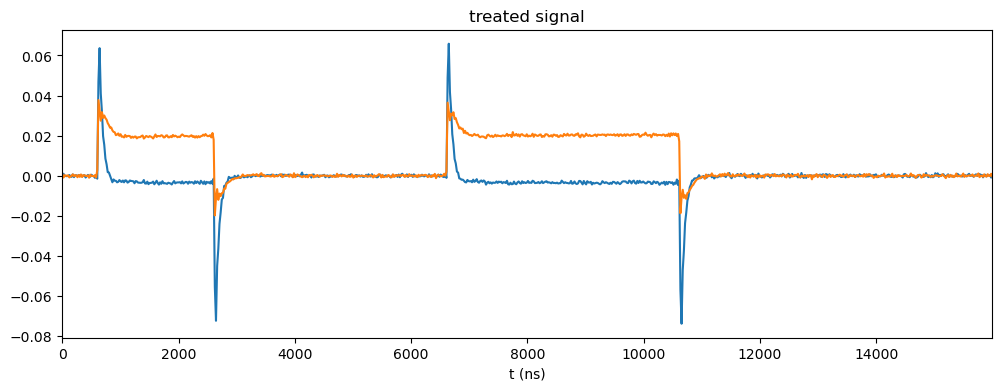

In [89]:
result_on_res = echo_data_treatment(data, 0, 16000, nco_f, tres=1e-9,
                                      baseline=True, baseline_start=-300, baseline_stop=-1,
                                      downconvert=True,
                                      filt=True, filt_opt={'bandwidth':50e6, 'centre':0e6},
                                      ph_corr=False,
                                      plot=True,
                                      plot_dem_filt=True)

### Ana's code

In [31]:
def setup_pulse_ringdown(pulse_amplitude, pulse_length, rec_del=int(1e9), avg_nb=1, steps=None, ctp=None, dummy_nb=0):

    waveforms = {
        "block01": {"data": [float(pulse_amplitude) for i in range(0, pulse_length)], "index": 1},
    }

    acquisitions = {
        "single": {"num_bins": 1, "index": 0},
    }

    prog = dedent(f"""
    acquire   0,0,4
    set_mrk   1011
    upd_param 246
    play      1,1,{pulse_length}   # play excitation waveform and wait its duration
    wait      {rec_del} # should be larger than 16400 - pulse_length - 250
    """).lstrip('\n')
    
    seq_prog = qblox_esr.simple2real_Q1ASM(
                                prog, avg_nb=avg_nb, shot_nb=1, dummy_nb=dummy_nb,
                                steps=steps, ctp=ctp, twt_triggers=False)

    sequence = {
        "waveforms": waveforms,
        "weights": {},
        "acquisitions": acquisitions,
        "program": seq_prog,
    }

    return sequence

def exp_decay(t, A, tau, offset):
    """Exponential decay function for fitting the ringdown signal."""
    return A * np.exp(-t / tau) + offset

def find_resonance(fr_guess, f_start, f_stop, f_npts, attenuation, ringdown_length, pulse_amplitude, pulse_length, rec_del, avg_nb, plot_all=True, plot=True):
        """Calculates the resonance frequency based on the input parameters.
        Input frequency in Hz and ringdown length in s
        """
        start_int = 9.8e-7 
        end_int = start_int + ringdown_length
        nco_f = 100e6

        sequence = setup_pulse_ringdown(pulse_amplitude=pulse_amplitude, pulse_length=pulse_length, rec_del=int(rec_del), avg_nb=int(avg_nb), steps=None, ctp=None, dummy_nb=0)
    
        freqs = np.linspace(f_start, f_stop, f_npts)
        
        results = []
        pulsing_freqs = []
        ringdown_freqs = []  # For plotting

        for freq_change in freqs:
            carrier_f = fr_guess + freq_change
            qblox_esr.qrm_rf_awg(qrm_rf, lo_freq=carrier_f-nco_f, nco_freq=nco_f, in0_att=0, out0_att=attenuation)
            qrm_rf.sequencer0.nco_prop_delay_comp_en(True)
            qrm_rf.sequencer0.sequence(sequence)  # sequence upload
            qrm_rf.arm_sequencer(0)
            qrm_rf.start_sequencer()
            data = get_data()
            result = echo_data_treatment(data, 0, 16400, nco_f, tres=1e-9,
                                                baseline=True, baseline_start=-300, baseline_stop=-1,
                                                downconvert=True,
                                                filt=True, filt_opt={'bandwidth':100e6, 'centre':0e6},
                                                ph_corr=False,
                                                plot=False,
                                                plot_dem_filt=False)
            results.append(result)
            pulsing_freqs.append(carrier_f)

            # Process ringdown signal
            data_x, data_y = result
            d = data_x[1]-data_x[0]
            n = int(10e5)
            fft_x = np.fft.fftfreq(n,d=d)
            
            start_i, end_i = np.searchsorted(data_x, [start_int * 1e9, end_int * 1e9])
            fft_y = np.abs(np.fft.fft(data_y[start_i:end_i],n=n))
            
            # Filter the fft_x and fft_y values to be within the range -0.02 and 0.02
            mask = (fft_x >= -0.015) & (fft_x <= 0.015)
            fft_x_filtered = fft_x[mask]
            fft_y_filtered = fft_y[mask]
            # Find the maximum within the restricted range
            ringdown_freqs.append(fft_x_filtered[np.argmax(fft_y_filtered)])    
            
            if plot_all:
                plt.figure(figsize=(8, 6))
                plt.plot(data_x,np.real(data_y), label='I')
                plt.plot(data_x,np.imag(data_y), label='Q')
                plt.axvline(start_int*1e9,color = "tab:green", label='Ringdown start')
                plt.axvline(end_int*1e9,color = "tab:red", label='Ringdown end')
                plt.xlim(400, end_int*1e9+1000)
                plt.xlabel('Time (ns)')
                plt.ylabel('Signal amplitude (a.u.)')
                plt.legend()
                plt.show()

                plt.figure(figsize=(8, 6))
                plt.scatter(fft_x,fft_y,s=0.1)
                plt.xlim(-0.015,0.015)
                plt.xlabel('Frequency (GHz)')
                plt.ylabel('Signal amplitude (a.u.)')
                plt.show()

        # Fit a polynomial to find resonance
        p = np.polyfit(freqs, np.array(ringdown_freqs) * 1e9, 11)
        roots = np.roots(p)
        real_roots = roots[np.isreal(roots)].real
        nearest_freq_index = np.argmin(np.abs(ringdown_freqs))
        nearest_freq = np.array(ringdown_freqs[nearest_freq_index]) * 1e9
        y0_crossing = real_roots[np.argmin(np.abs(real_roots - freqs[nearest_freq_index]))]
        res_freq = fr_guess + y0_crossing
        
        # Plot the ringdown frequencies vs. pulsing frequencies
        if plot:
            plt.figure(figsize=(8, 6))
            plt.scatter(freqs, np.array(ringdown_freqs) * 1e9, s=5)
        
            poly = np.poly1d(p)
            plt.plot(freqs, poly(freqs), alpha=0.5)
        
            plt.axhline(y=0, color='red')
            plt.scatter(y0_crossing, 0, color='red', s=5)
            plt.scatter(freqs[nearest_freq_index], nearest_freq, color='purple', s=5)
            plt.xlabel("Pulse frequency (Hz)")
            plt.ylabel("Ringdown frequency (Hz)")
            plt.show()


        return res_freq

def take_trace_at_resonance(res_freq, attenuation, pulse_amplitude, pulse_length, rec_del, avg_nb):
    """Takes another trace at the resonance frequency with more averages."""
    nco_f = 100e6

    sequence = setup_pulse_ringdown(pulse_amplitude=pulse_amplitude, pulse_length=pulse_length, rec_del=int(rec_del), avg_nb=int(avg_nb*10), steps=None, ctp=None, dummy_nb=0)
    carrier_f = res_freq
    qblox_esr.qrm_rf_awg(qrm_rf, lo_freq=carrier_f-nco_f, nco_freq=nco_f, in0_att=0, out0_att=attenuation)
    qrm_rf.sequencer0.nco_prop_delay_comp_en(True)
    qrm_rf.sequencer0.sequence(sequence)  # sequence upload
    qrm_rf.arm_sequencer(0)
    qrm_rf.start_sequencer()
    data = get_data()
    result = echo_data_treatment(data, 0, 16400, nco_f, tres=1e-9,
                                        baseline=True, baseline_start=-300, baseline_stop=-1,
                                        downconvert=True,
                                        filt=True, filt_opt={'bandwidth':100e6, 'centre':0e6},
                                        ph_corr=False,
                                        plot=False,
                                        plot_dem_filt=False)
    return result

def calculate_quality_factor(res_freq, attenuation, ringdown_length, pulse_amplitude, pulse_length, rec_del, avg_nb, plot=True):
    """Calculates the quality factor based on the resonance frequency and the ringdown data."""

    data = take_trace_at_resonance(res_freq, attenuation, pulse_amplitude, pulse_length, rec_del, avg_nb)
    
    start_int = 9.8e-7
    end_int = start_int + ringdown_length * 5
    
    data_x, data_y = data
    start_i, end_i = np.searchsorted(data_x, [start_int * 1e9, end_int * 1e9])
    ringdown_signal = np.abs(data_y[start_i:end_i])

    try:
        p0 = [np.max(ringdown_signal), 1000, np.min(ringdown_signal)]
        popt, _ = curve_fit(exp_decay, data_x[start_i:end_i], ringdown_signal, p0=p0)
        tau = popt[1]/1e9  # Extracting the decay time constant (tau)
        Q = np.pi * res_freq * tau  # Calculate the quality factor

        if plot:
            # Plot the data and the fit
            plt.figure(figsize=(8, 6))
            plt.plot(data_x[start_i:end_i], ringdown_signal, 'bo', markersize=4, label="Ringdown data")
            
            # Generate the fit curve
            fit_y = exp_decay(data_x[start_i:end_i], *popt)
            plt.plot(data_x[start_i:end_i], fit_y, 'r-', label=f"Fit: A*exp(-t/tau) + offset\n$\\tau$ = {round(tau*1e6, 2)} us")
    
            # Plot vertical lines showing the range of data taken for fitting
            plt.axvline(data_x[start_i], color='green', linestyle='--')
            plt.axvline(data_x[end_i], color='green', linestyle='--')
    
            # Add labels and legend
            plt.xlabel("Time (ns)")
            plt.ylabel('Signal amplitude (a.u.)')
            plt.title(f"Resonance frequency = {res_freq * 1e-6:.3f} MHz, Q = {round(Q)}, bandwidth = {round(res_freq * 1e-6 / Q, 2)} MHz")
            plt.legend()
            plt.show()
            
        return Q
        
    except RuntimeError as e:
        print(f"Failed to fit decay curve at {res_freq * 1e-6:.3f} MHz: {e}")
        return None

def find_resonance_and_quality_factor(fr_guess, f_start=-4e6, f_stop=4e6, f_npts=15, attenuation=30, ringdown_length=140e-9, pulse_amplitude=0.51, pulse_length=500, rec_del=int(20e3), avg_nb=int(10e3), plot_all=True, plot=True):
    
    res_freq = find_resonance(fr_guess=fr_guess, f_start=f_start, f_stop=f_stop, f_npts=f_npts, attenuation=attenuation, ringdown_length=ringdown_length, pulse_amplitude=pulse_amplitude, pulse_length=pulse_length, rec_del=rec_del, avg_nb=avg_nb, plot_all=plot_all, plot=plot)
    Q = calculate_quality_factor(res_freq=res_freq, attenuation=attenuation, ringdown_length=ringdown_length, pulse_amplitude=pulse_amplitude, pulse_length=pulse_length, rec_del=rec_del, avg_nb=avg_nb, plot=plot)

    return res_freq, Q

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


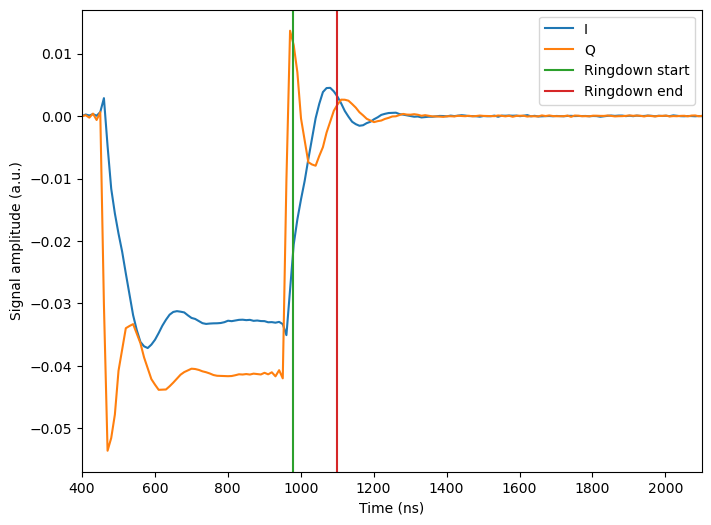

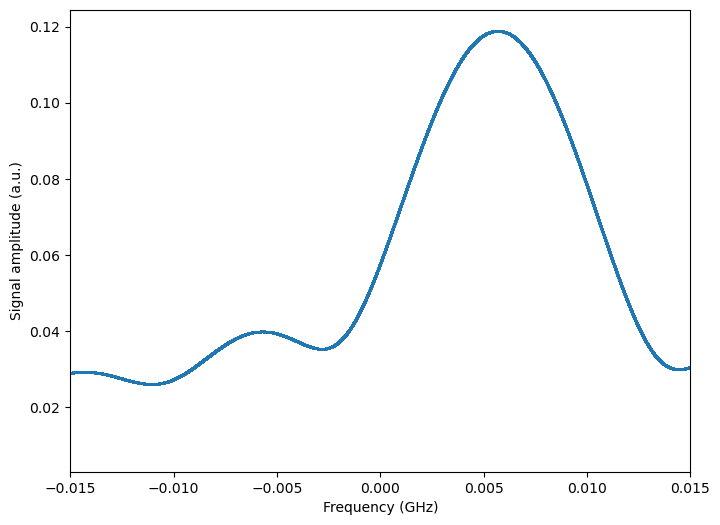

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


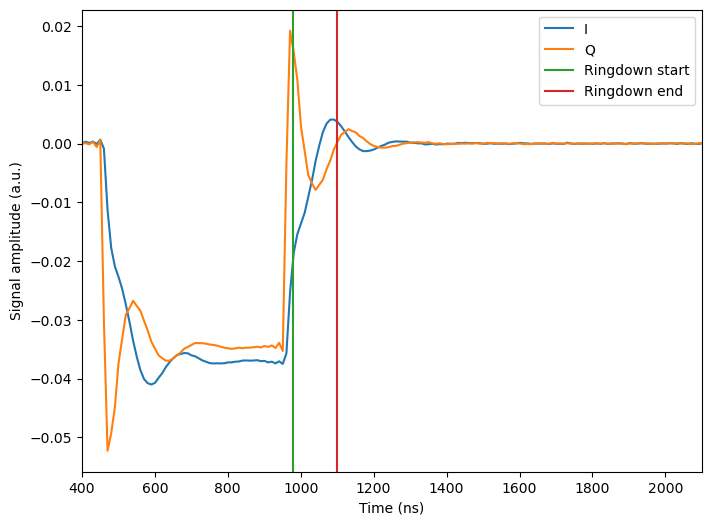

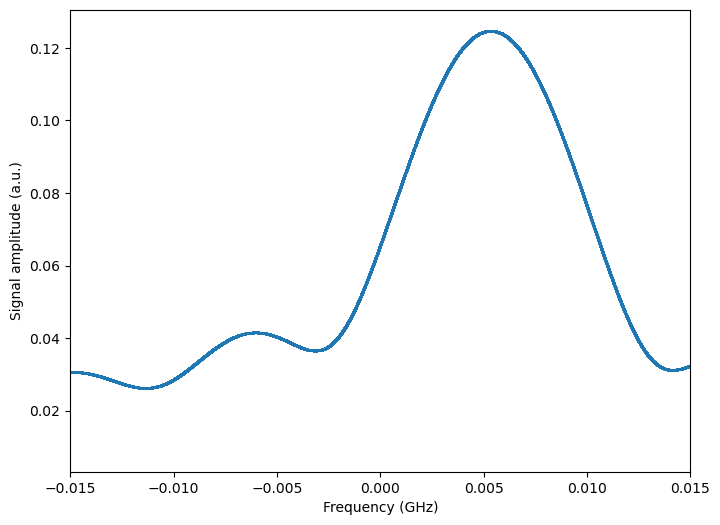

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


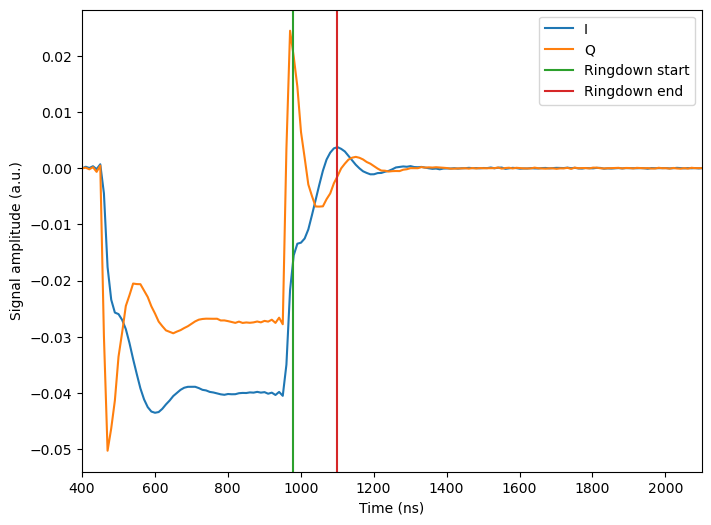

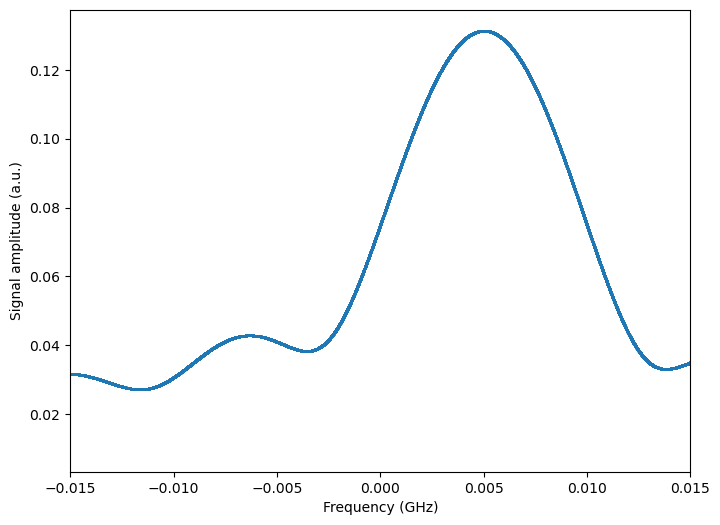

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


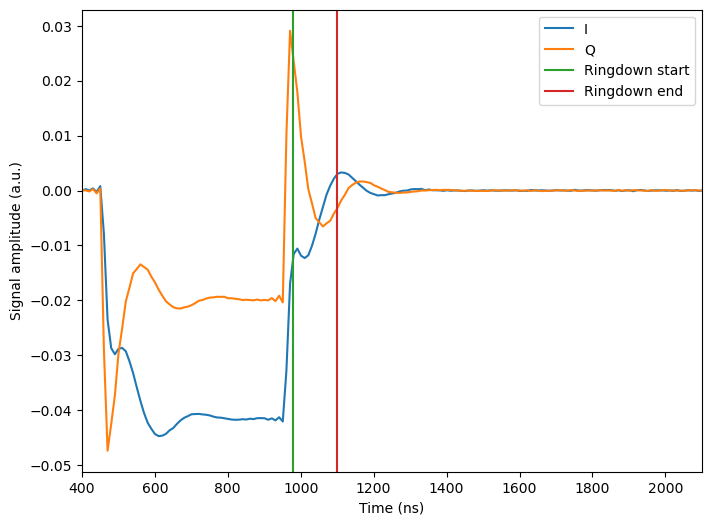

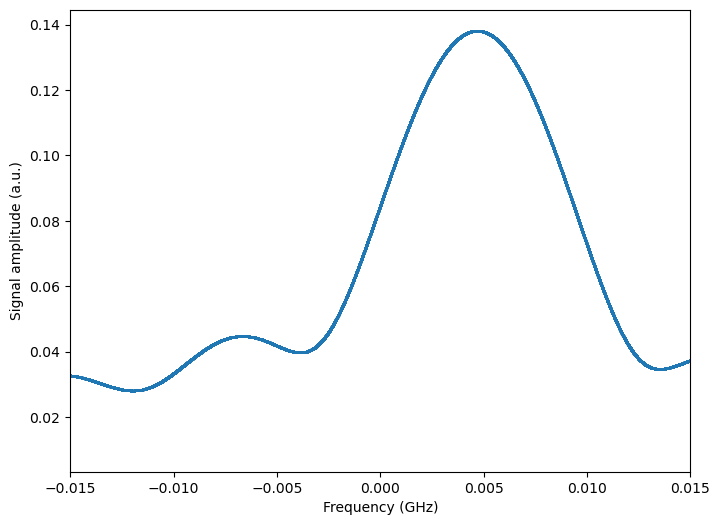

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


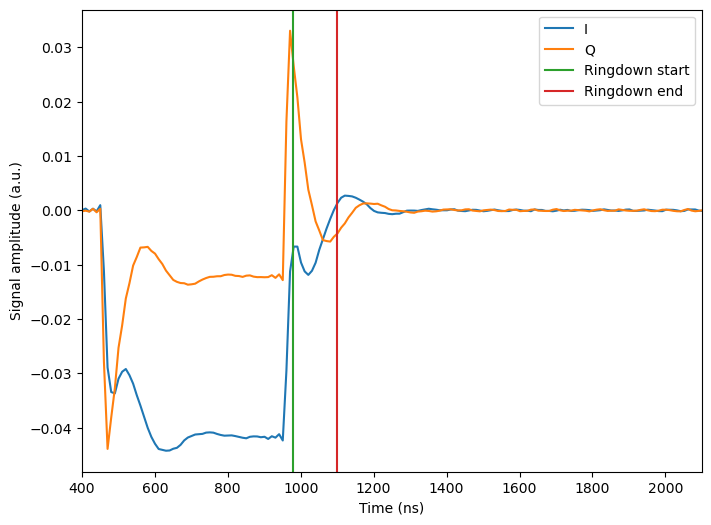

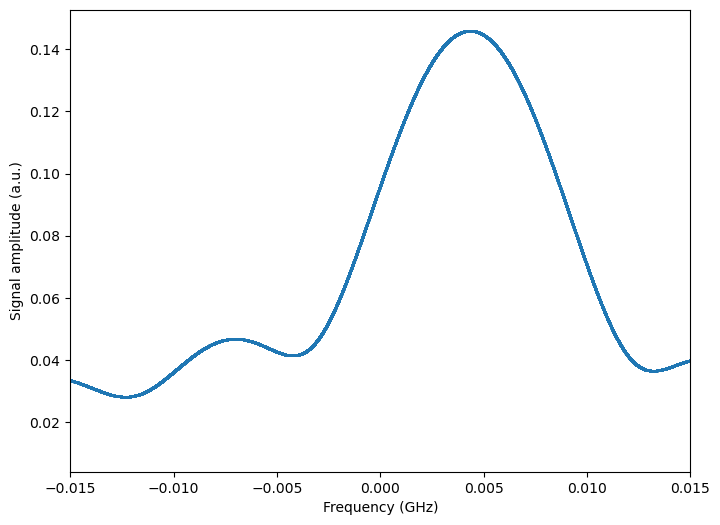

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


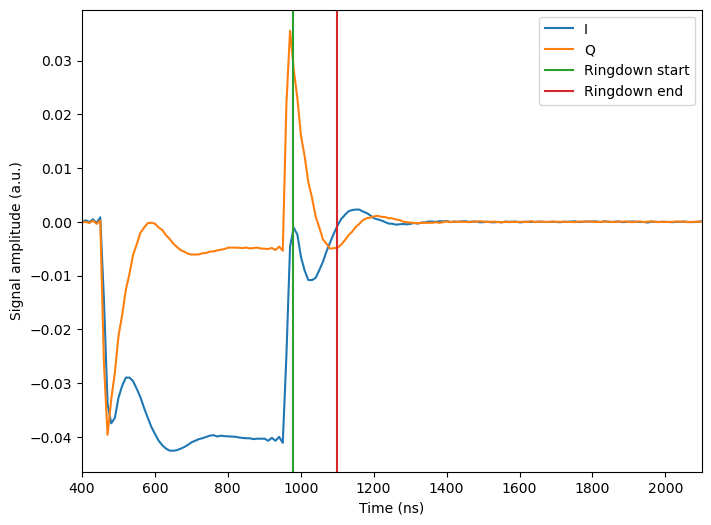

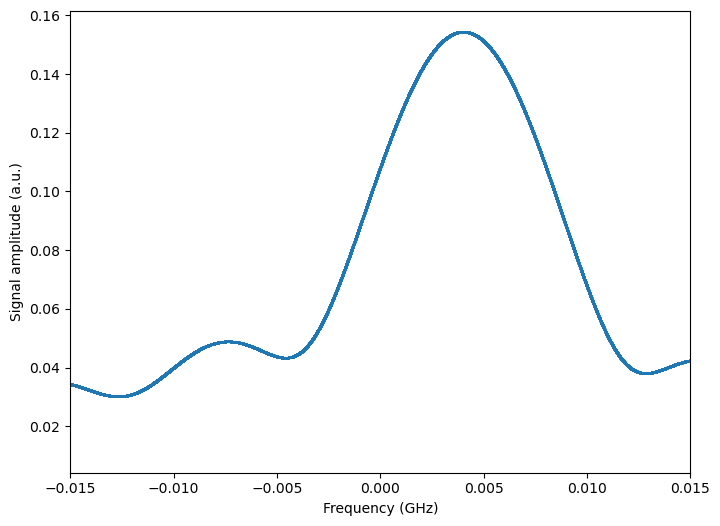

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


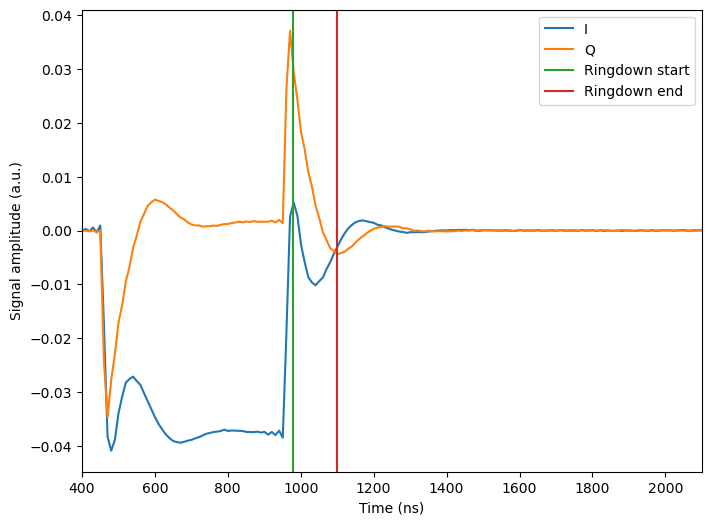

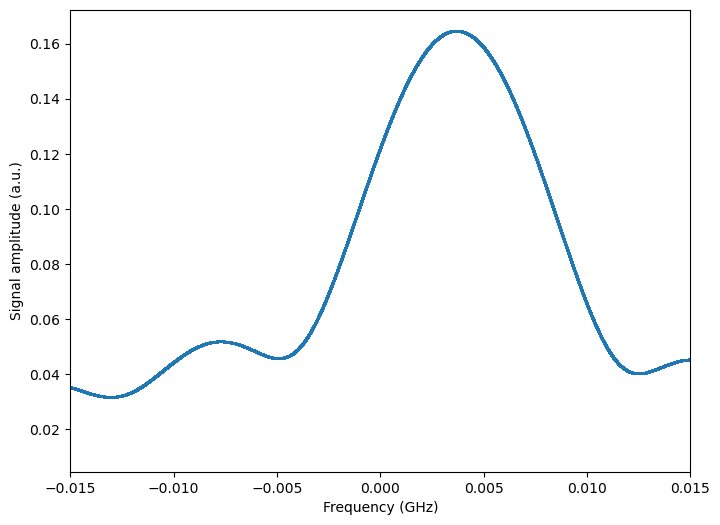

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


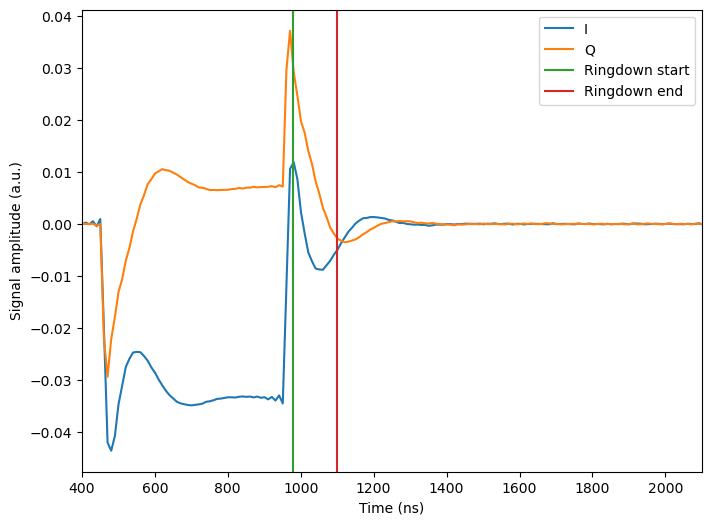

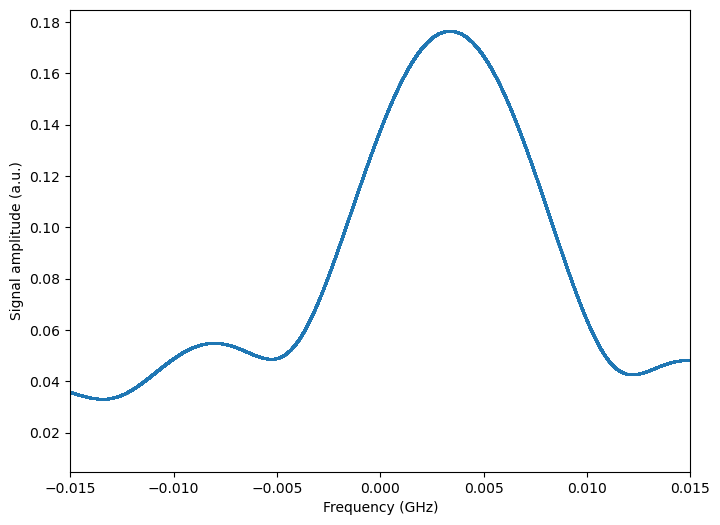

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


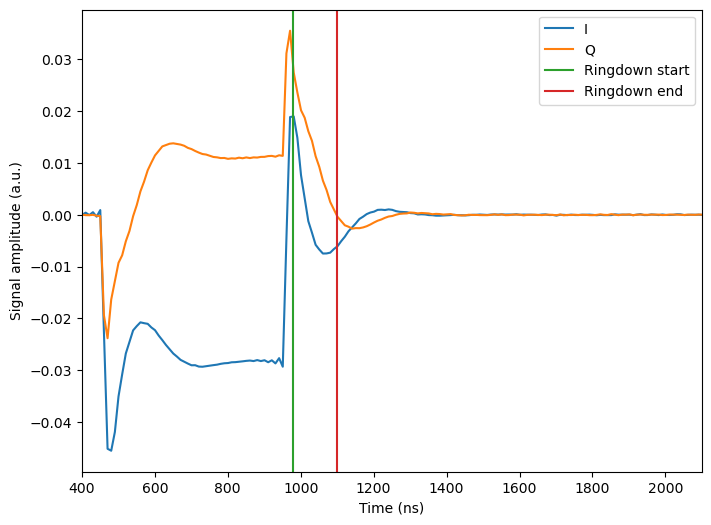

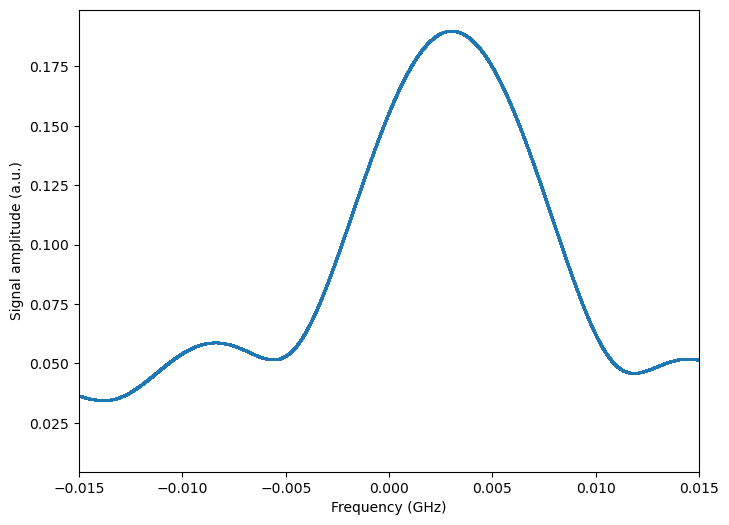

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


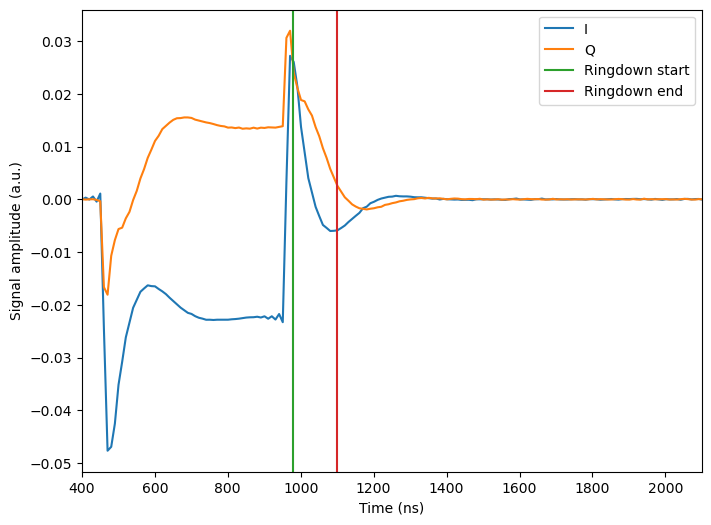

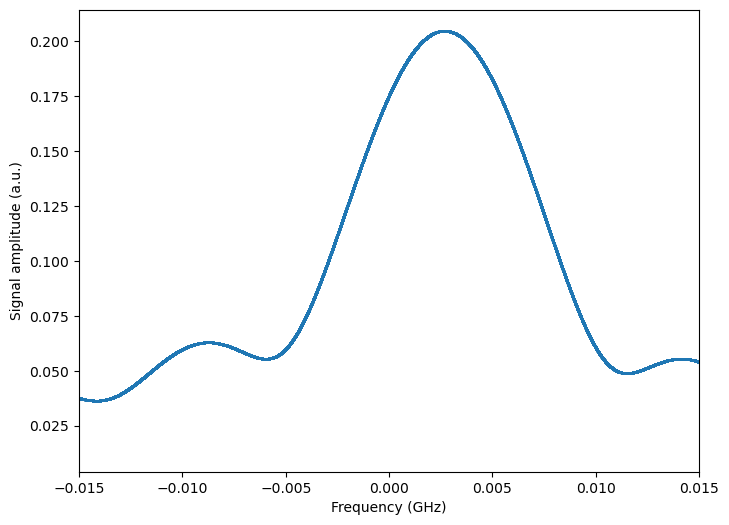

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


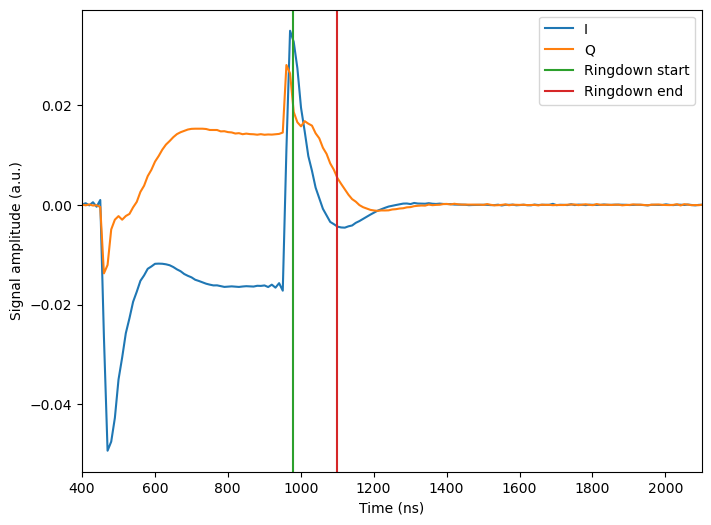

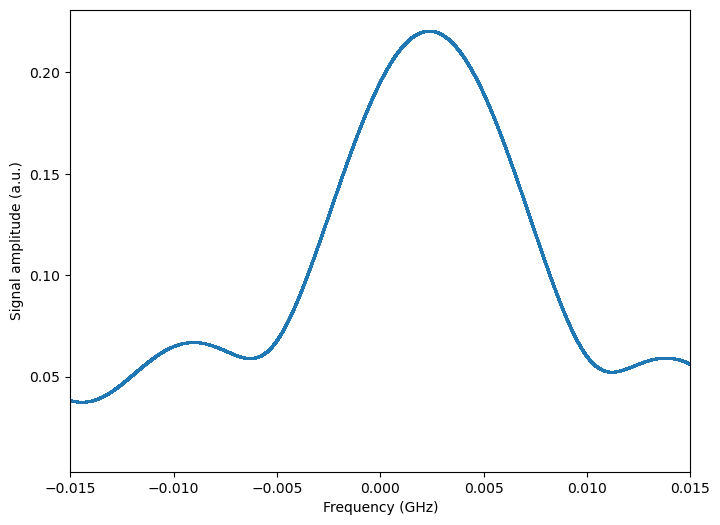

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


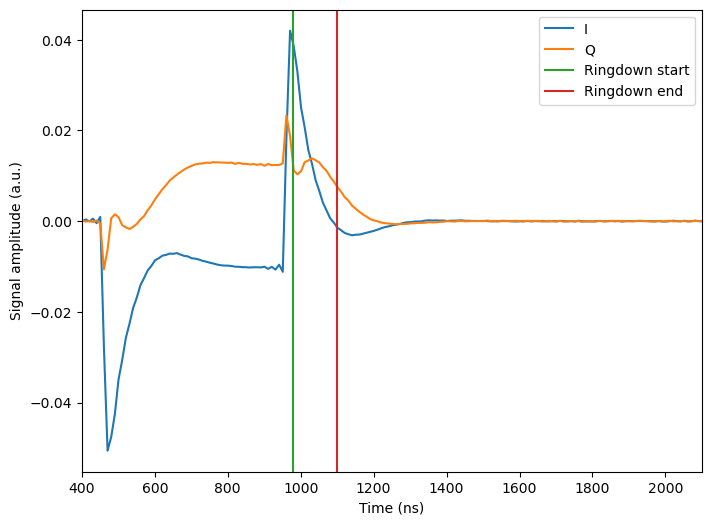

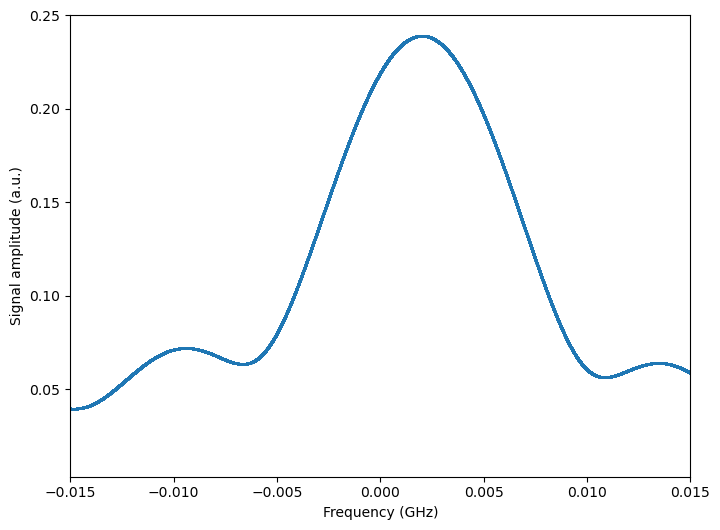

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


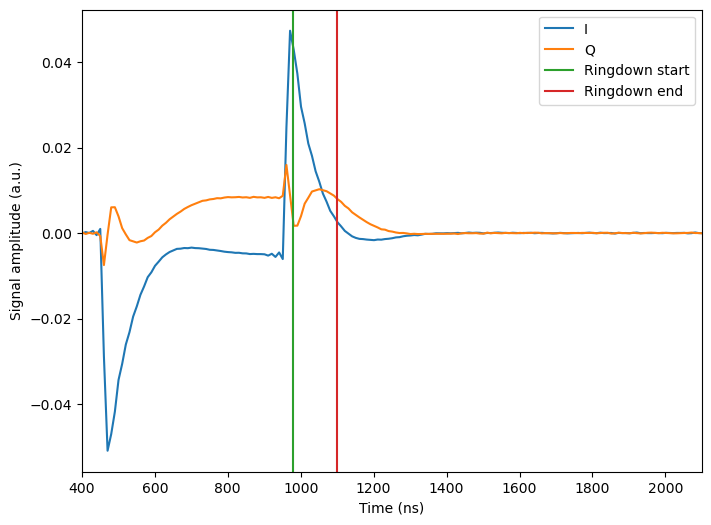

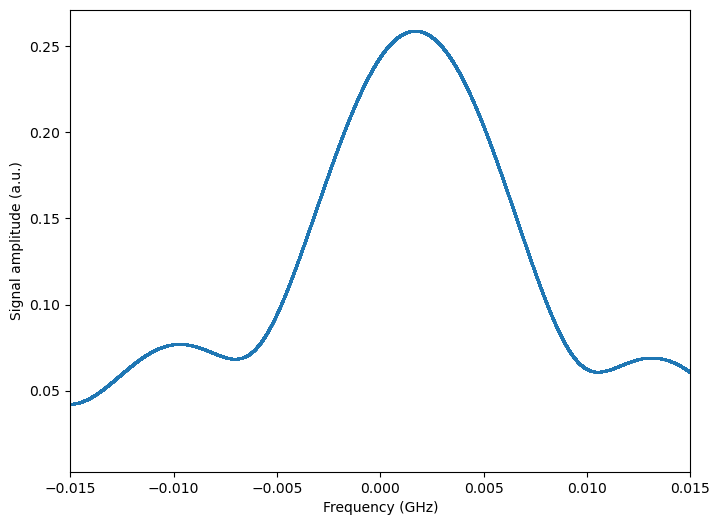

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


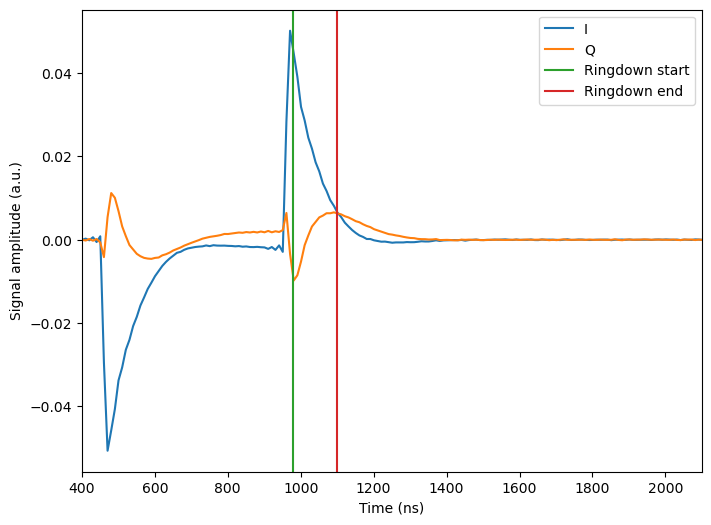

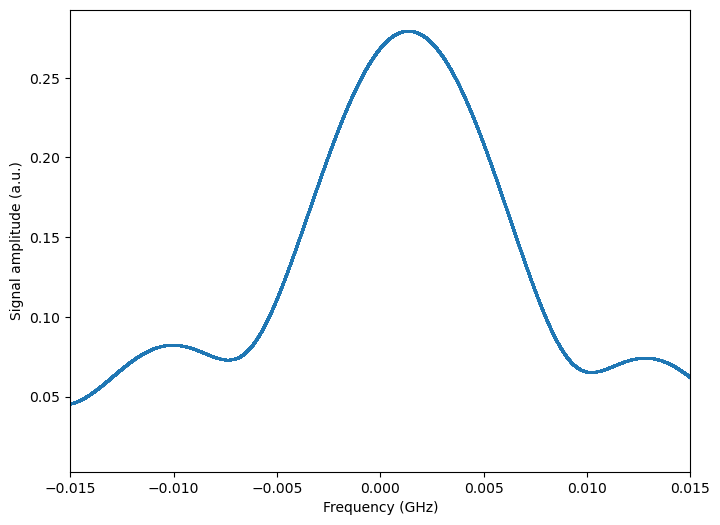

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


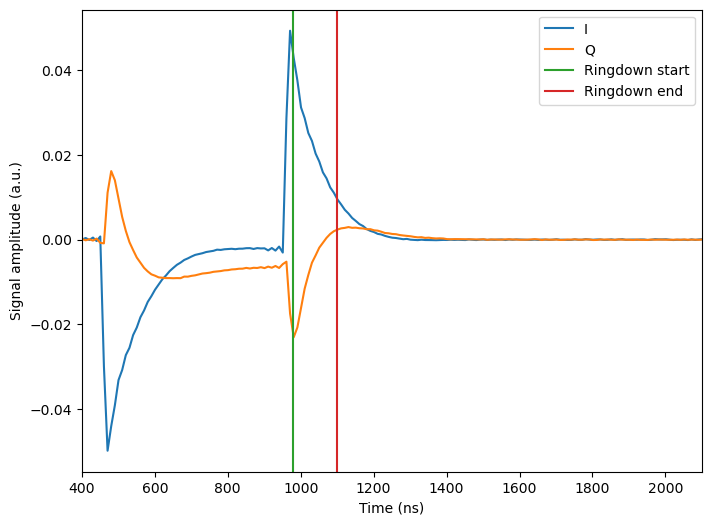

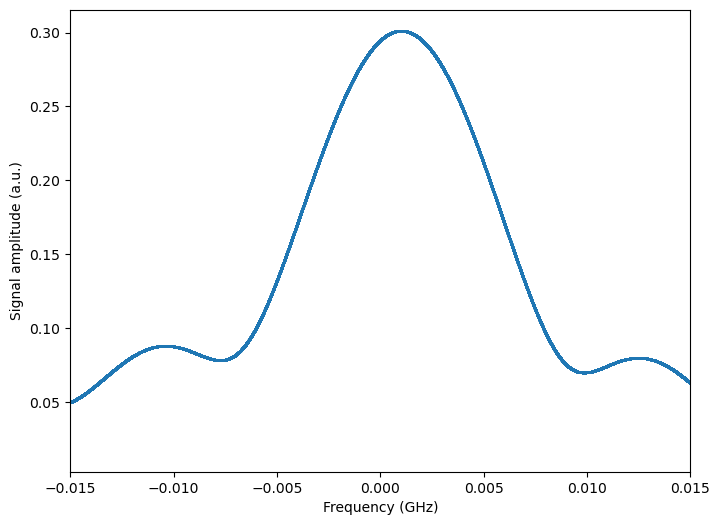

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


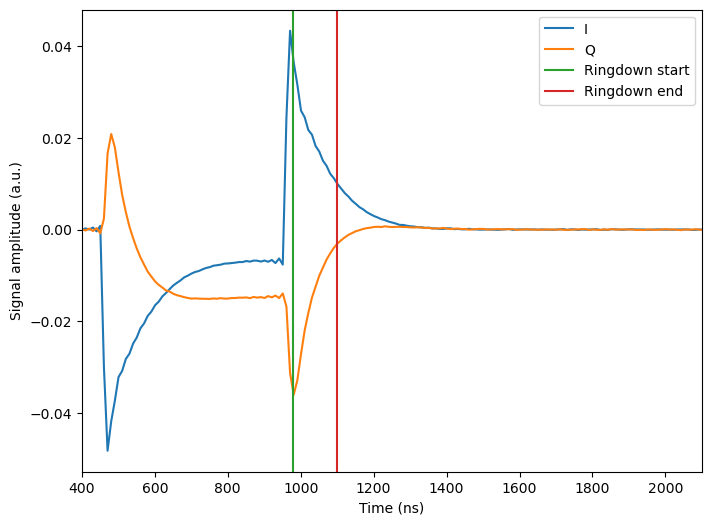

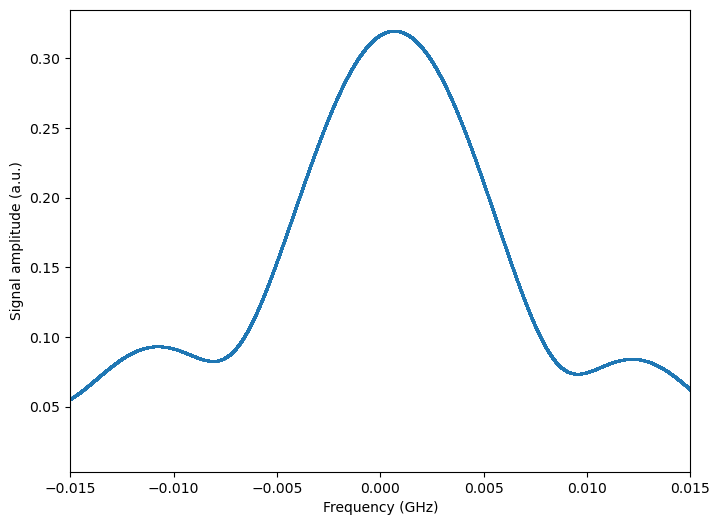

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


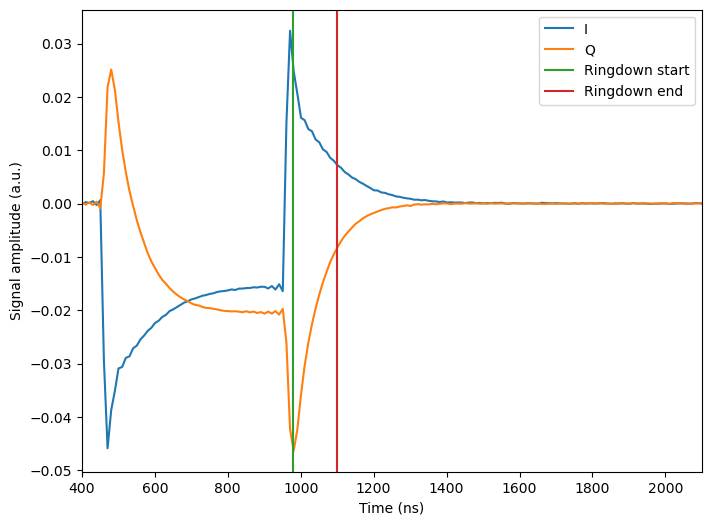

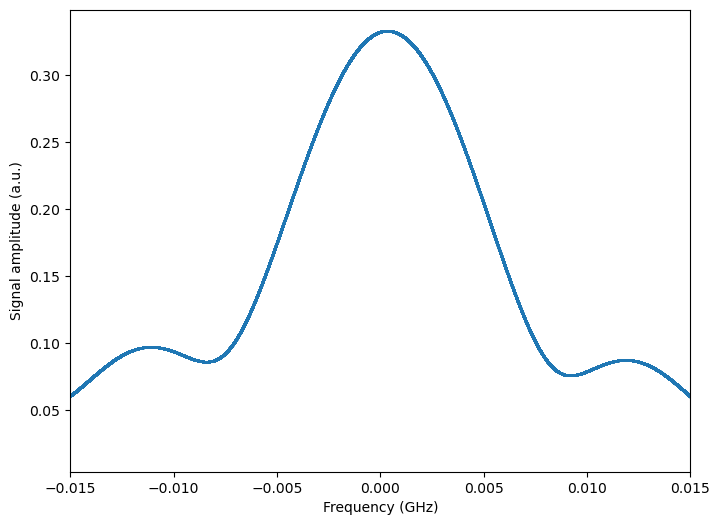

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


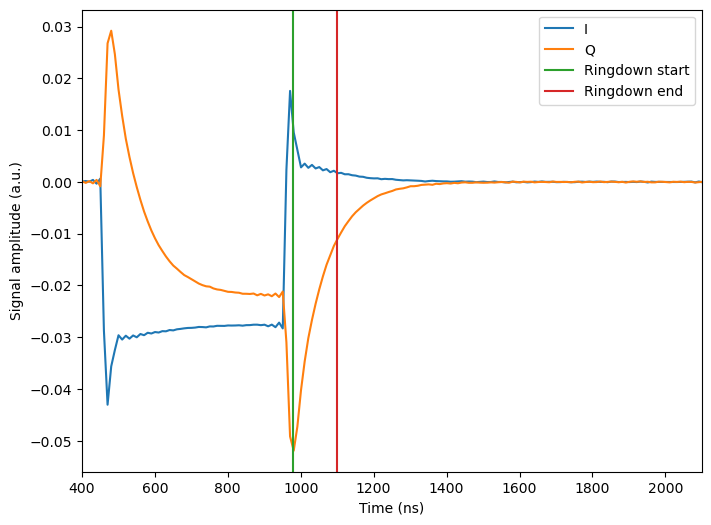

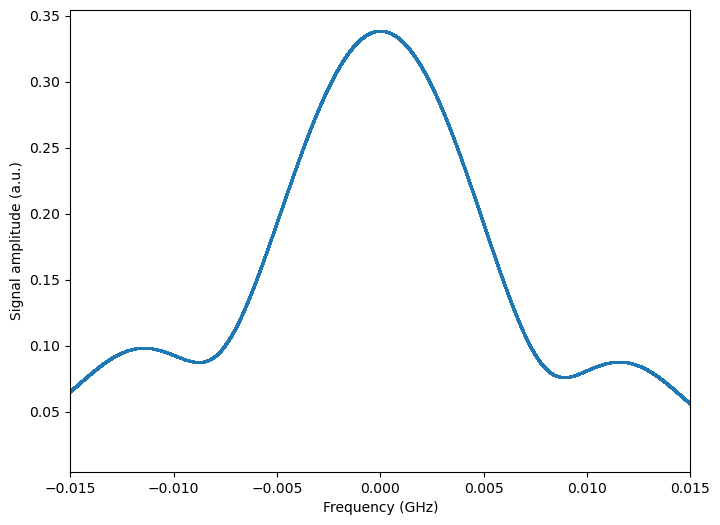

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


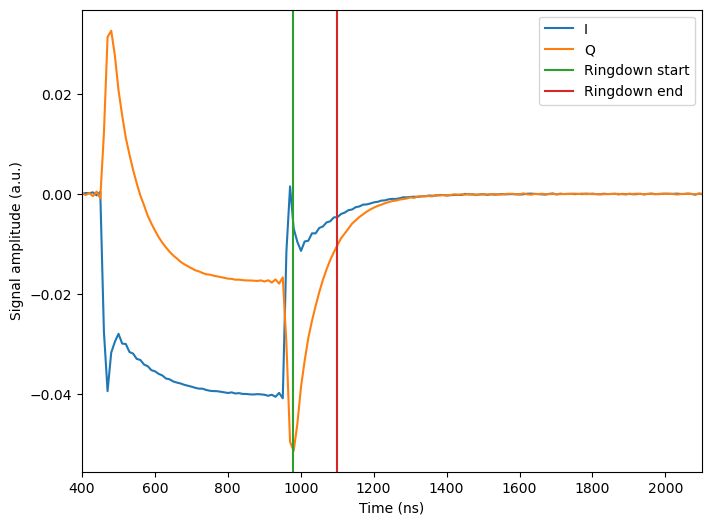

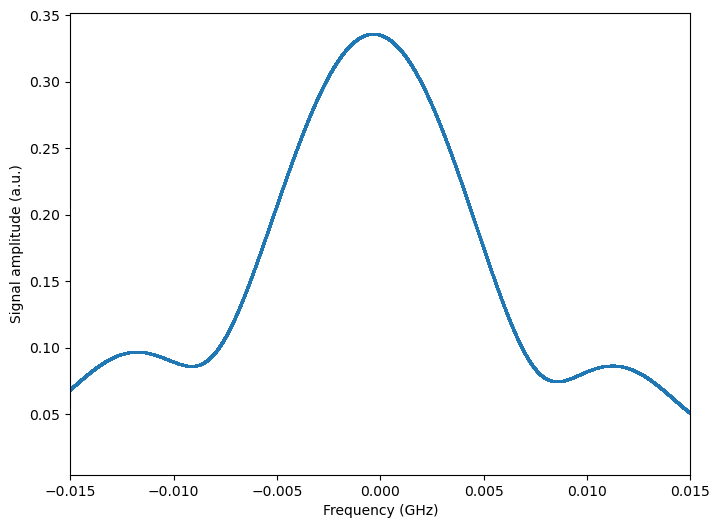

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


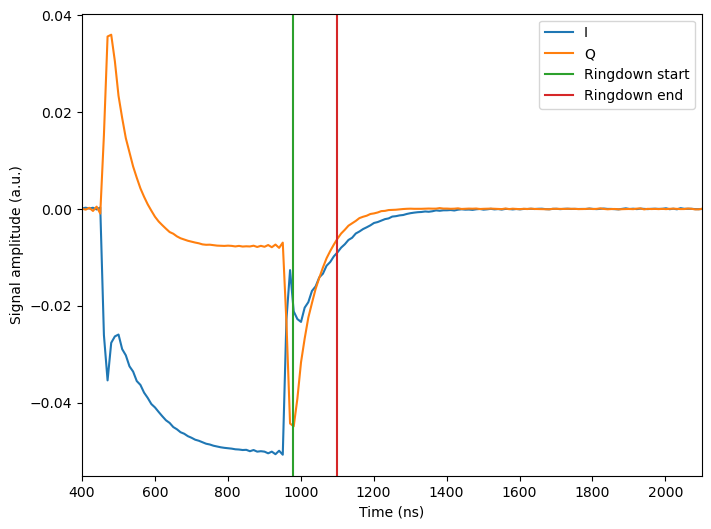

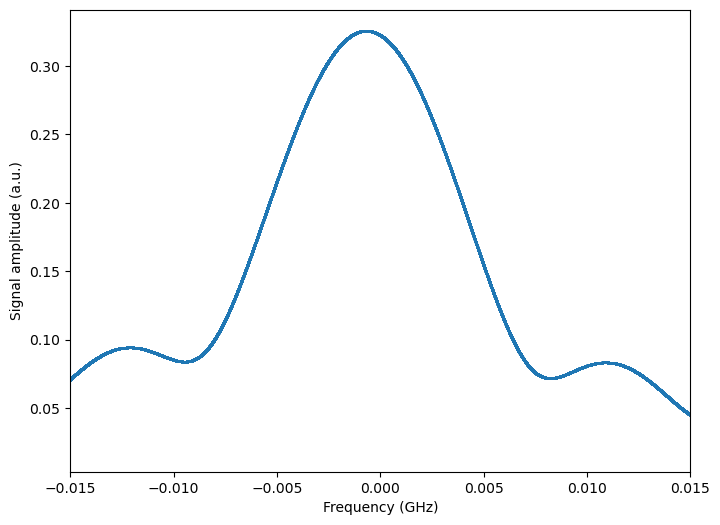

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


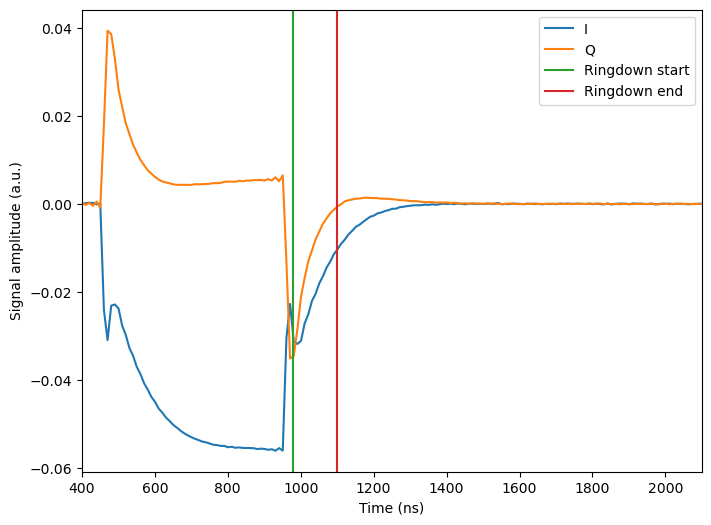

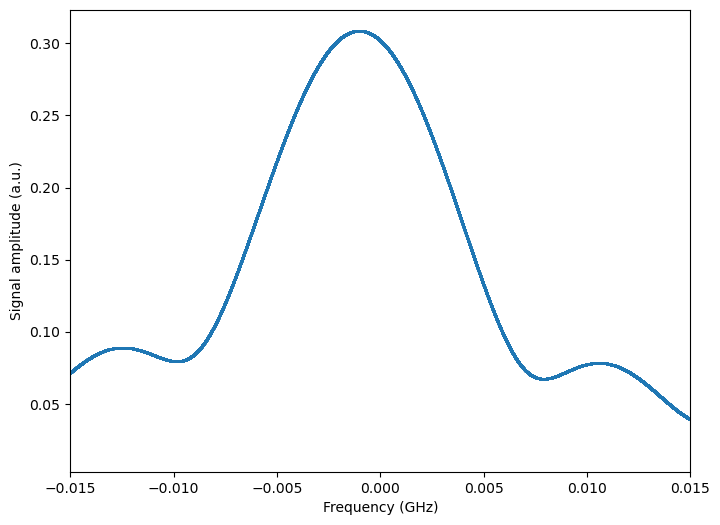

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


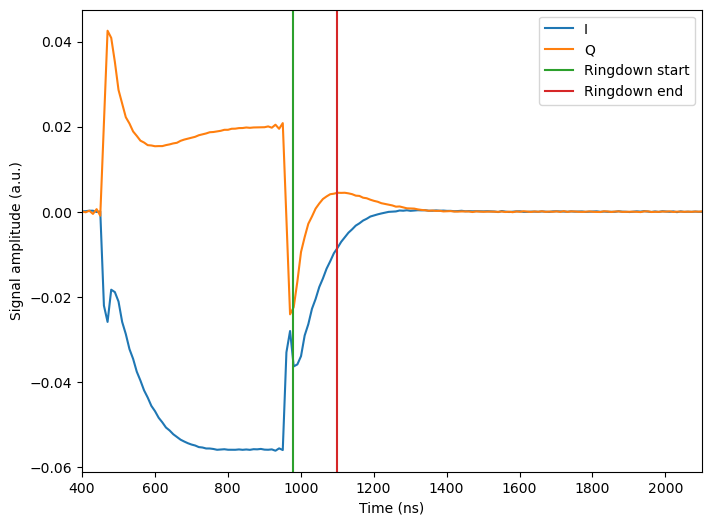

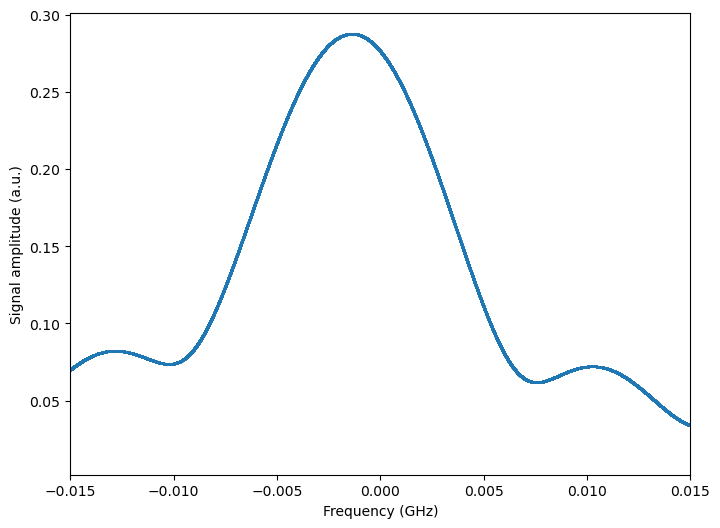

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


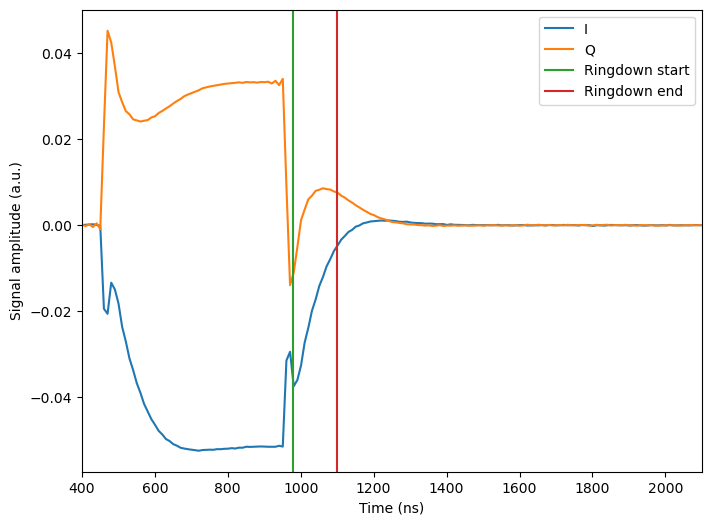

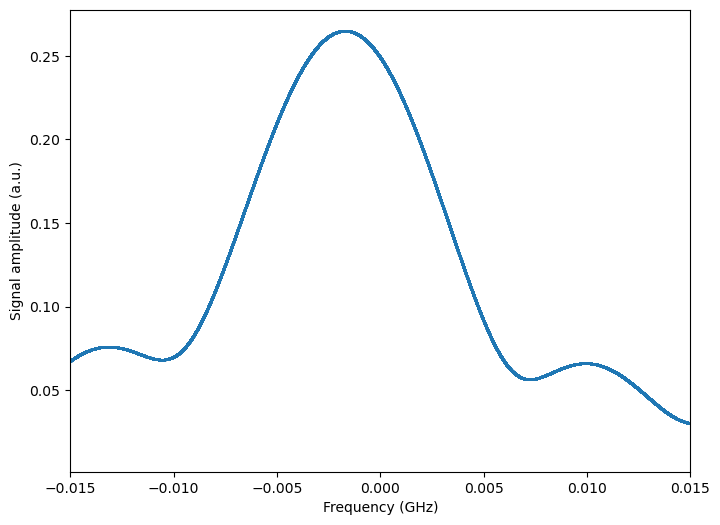

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


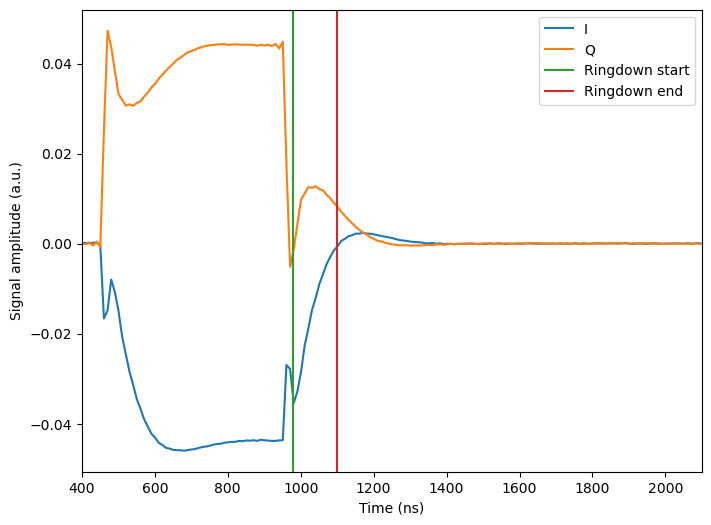

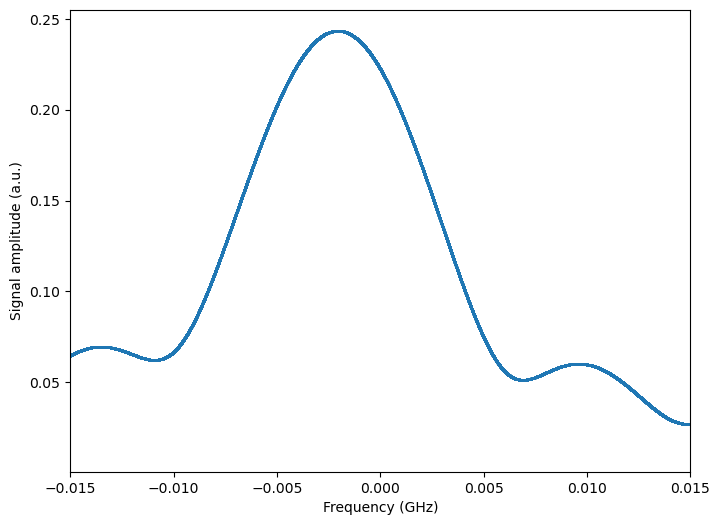

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


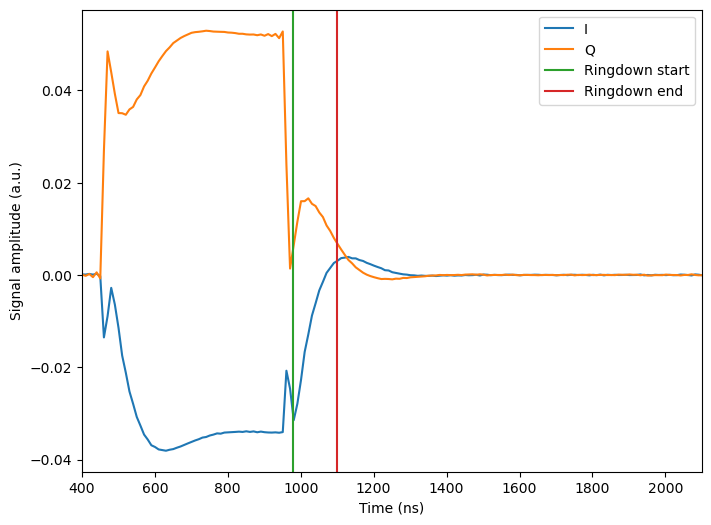

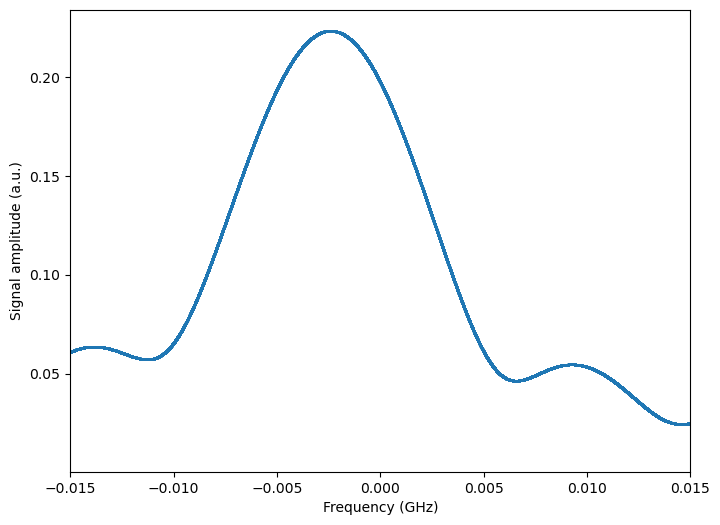

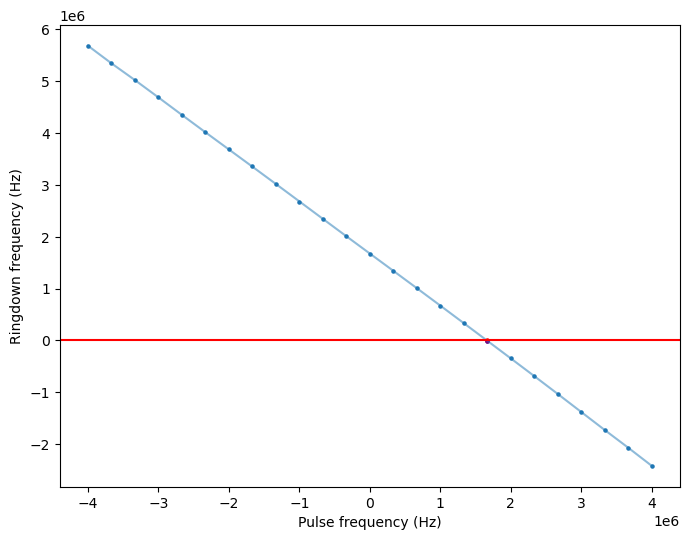

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


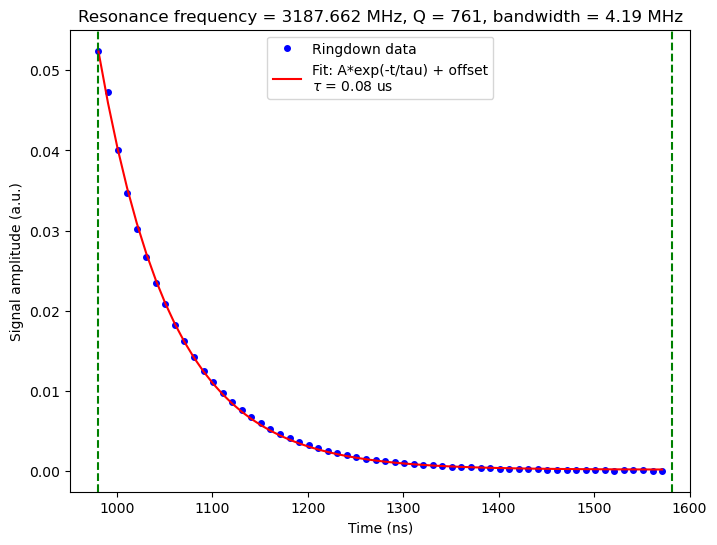

In [32]:
from scipy.optimize import curve_fit
res_freq, Q = find_resonance_and_quality_factor(fr_guess=3186e6, f_start=-4e6, f_stop=4e6, f_npts=25, attenuation=10, ringdown_length=120e-9, pulse_amplitude=0.51, pulse_length=500, rec_del=int(20e3), avg_nb=int(10e2), plot_all=True, plot=True)

## looking for echo

In [92]:
theta = 90-1.787
phi = 0.084
magnet_options = {"phi": phi, "theta": theta, "step":1}
_ = measure.set_magnetic_field(magnet, 10.2, magnet_type="AM1430", sleep_time=2, options=magnet_options)

Starting at field 10.31mT
Setting field to 10.20mT


# Echo at a field

In [170]:
freq_pulse = fc # 2187.662e6
nco_f = 100e6

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


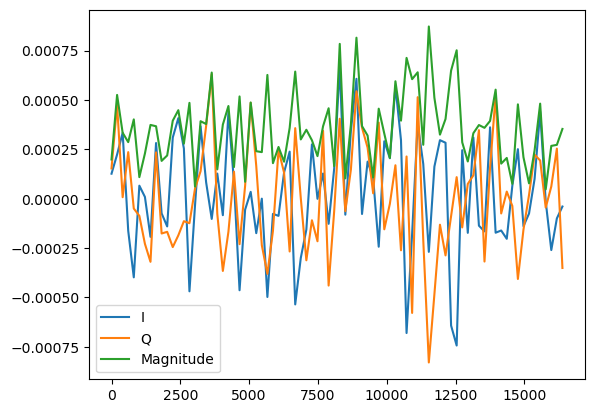

In [171]:
attenuation = 10
amp = 1
len_pi_over_2 = int(8e3)
len_pi = 2*len_pi_over_2
tau = int(40e3)
rec_del = int(10e9)
avg_nb = 1
dummy_nb = 0
steps=None
ctp=None
sequence = setup_hahnecho(amp, len_pi_over_2, len_pi, tau, rec_del, avg_nb=avg_nb, acq_pos=-5000, steps=None, ctp=None, dummy_nb=dummy_nb)
qblox_esr.qrm_rf_awg(qrm_rf, lo_freq=freq_pulse-nco_f, nco_freq=nco_f, in0_att=0, out0_att=int(attenuation))
qrm_rf.sequencer0.nco_prop_delay_comp_en(True)

qblox_esr.config_acq(qrm_rf, integ_len=10000)
qrm_rf.sequencer0.sequence(sequence) 
qrm_rf.arm_sequencer(0)
qrm_rf.start_sequencer()
data = get_data()
data_int = get_data_int()
result_on_res = echo_data_treatment(data, 0, None, nco_f, tres=1e-9,
                                      baseline=True, baseline_start=-300, baseline_stop=-1,
                                     downconvert=True,
                                     filt=True, filt_opt={'bandwidth':5e6, 'centre':0e6},
                                       ph_corr=True,
                                       plot=False,
                                       plot_dem_filt=False)
plt.plot(result_on_res[0], np.real(result_on_res[1]), label='I')
plt.plot(result_on_res[0], np.imag(result_on_res[1]), label='Q')
plt.plot(result_on_res[0], np.abs(result_on_res[1]), label='Magnitude')
plt.legend()
plt.show()

## new acquire

In [102]:
attenuation = 10
amp = 1
len_pi_over_2 = int(8e3)
len_pi = 2*len_pi_over_2
tau = int(40e3)
rec_del = int(1e9)
avg_nb = 1
dummy_nb = 0
steps=None
ctp=None
sequence = setup_hahnecho2(amp, len_pi_over_2, len_pi, tau, rec_del, avg_nb=avg_nb, acq_pos=-35000, steps=None, ctp=None, dummy_nb=dummy_nb, acq_tres=300, acq_npts=5000)
qblox_esr.qrm_rf_awg(qrm_rf, lo_freq=freq_pulse-nco_f, nco_freq=nco_f, in0_att=0, out0_att=int(attenuation))
qrm_rf.sequencer0.nco_prop_delay_comp_en(True)

qblox_esr.config_acq(qrm_rf, integ_len=300)
qrm_rf.sequencer0.sequence(sequence) 
qrm_rf.arm_sequencer(0)
qrm_rf.start_sequencer()
data = get_data()
data_int = get_data_int()
result_on_res = echo_data_treatment(data_int, None, None, nco_f, tres=300e-9,
                                      baseline=True, baseline_start=-300, baseline_stop=-1,
                                      downconvert=True,
                                      filt=True, filt_opt={'bandwidth':5e6, 'centre':0e6},
                                      ph_corr=True,
                                      plot=False,
                                      plot_dem_filt=False)
# plt.plot(result_on_res[0], np.real(result_on_res[1]), label='I')
# plt.plot(result_on_res[0], np.imag(result_on_res[1]), label='Q')
# plt.plot(result_on_res[0], np.abs(result_on_res[1]), label='Magnitude')
# plt.legend()
# plt.show()

Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


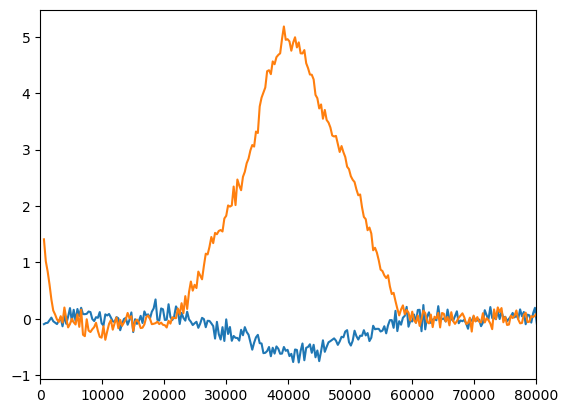

In [103]:
t = np.linspace(300, 300*5000, 5000)

plt.figure()
plt.plot(t,np.real(data_int))
plt.plot(t,np.imag(data_int))
plt.xlim(0,80000)
plt.show()

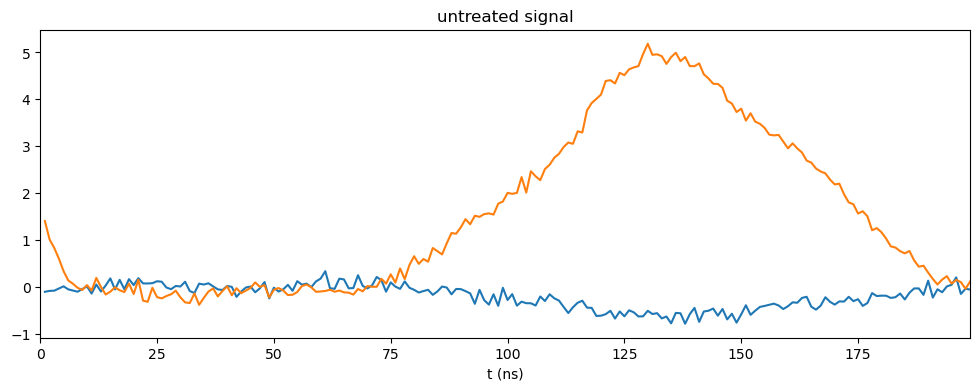

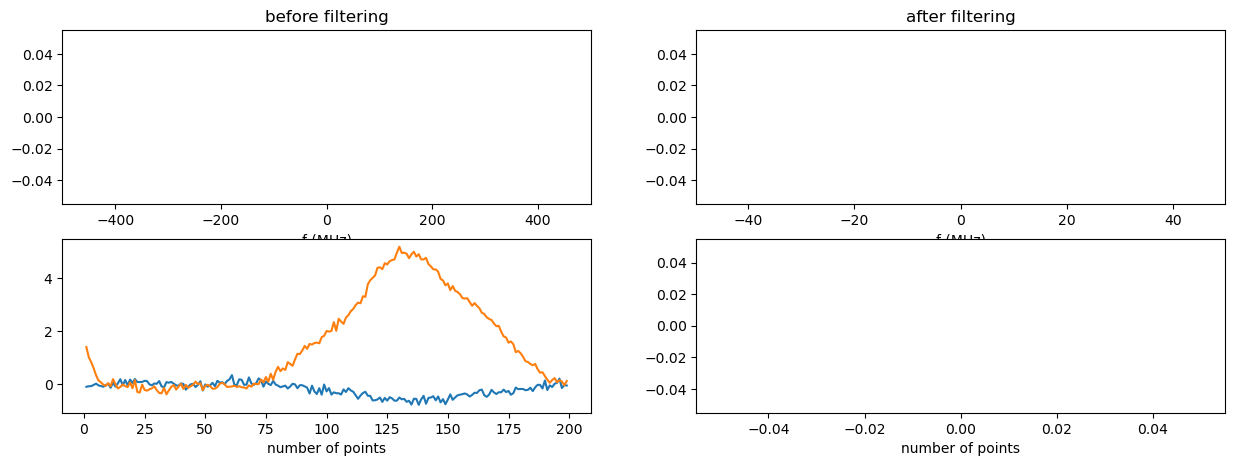

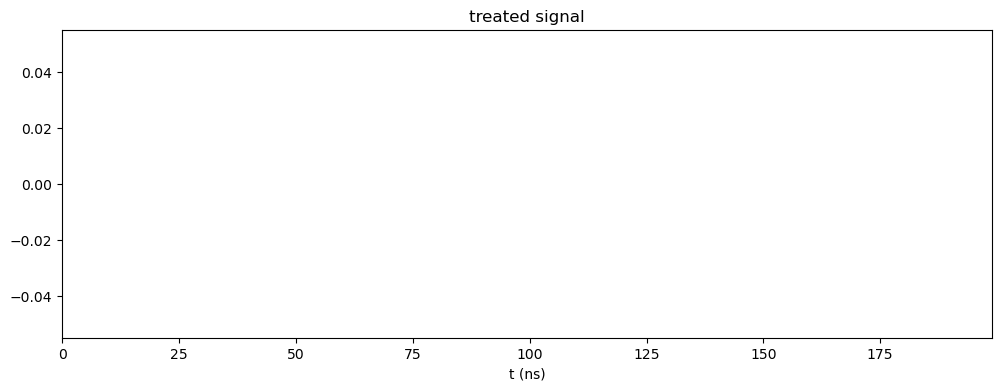

In [104]:
result_on_res = echo_data_treatment(data_int, 0, 200, nco_f, tres=1e-9,
                                      baseline=True, baseline_start=-100, baseline_stop=-1,
                                      downconvert=False,
                                      filt=True, filt_opt={'bandwidth':100e6, 'centre':0e6},
                                      ph_corr=True,
                                      plot=True,
                                      plot_dem_filt=True)

In [98]:
theta = -1.787
phi = 0.084
magnet_options = {"phi": phi, "theta": theta, "step":5}
_ = measure.set_magnetic_field(magnet, 54.1, magnet_type="AM1430", sleep_time=10, options=magnet_options)

Starting at field 53.59mT
Setting field to 54.10mT


#### EDFS

In [74]:
steps=[0,180]
ctp=[-1,+2]

In [31]:
freq_pulse = 3187.662e6
nco_f = 100e6

In [112]:
SPEC_mode()

In [306]:
VNA_mode()

## Resonator tracking with field

In [31]:
# in T!
ix.field(0)
iy.field(0)
iz.field(0)

In [178]:
fields = np.linspace(47.2, 47, 21)
print(fields)

[47.2  47.19 47.18 47.17 47.16 47.15 47.14 47.13 47.12 47.11 47.1  47.09
 47.08 47.07 47.06 47.05 47.04 47.03 47.02 47.01 47.  ]


Starting at field 46.80mT
Setting field to 47.60mT
Setting field to 48.40mT
Setting field to 49.20mT
Starting at field 49.20mT
Setting field to 48.40mT
Setting field to 47.60mT
Setting field to 47.20mT
field: 47.20288994807415mT
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


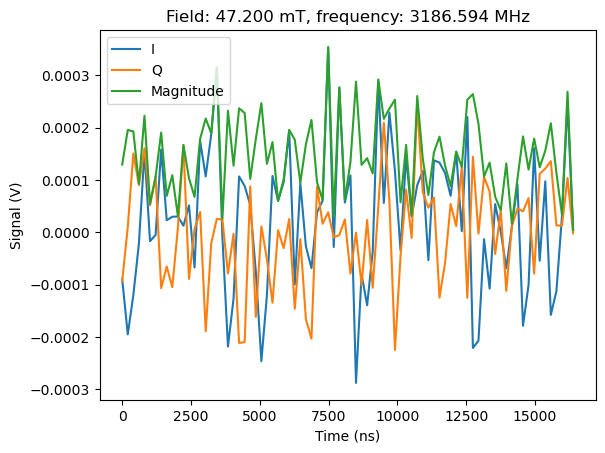

Starting at field 47.20mT
Setting field to 47.19mT
field: 47.1870576355424mT
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


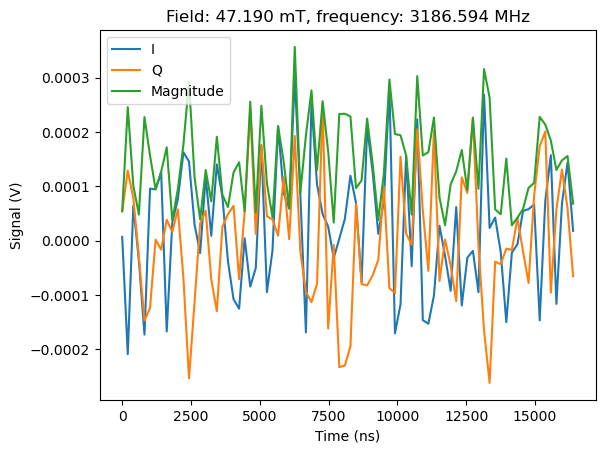

Starting at field 47.19mT
Setting field to 47.18mT
field: 47.17878004251488mT
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


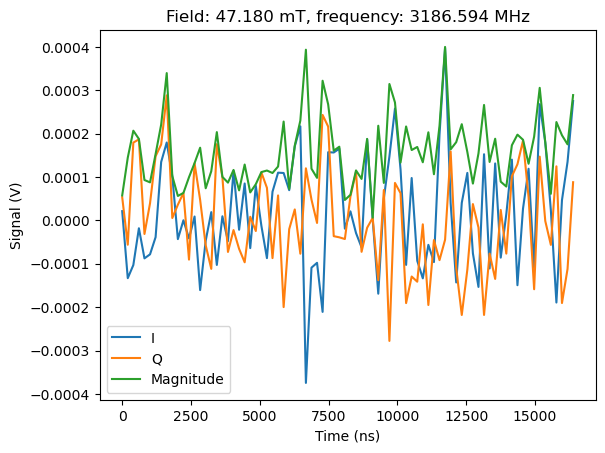

Starting at field 47.18mT
Setting field to 47.17mT
field: 47.17200922803691mT
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


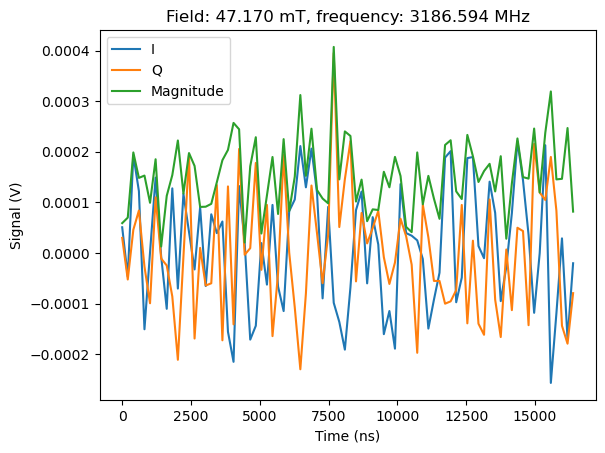

Starting at field 47.17mT
Setting field to 47.16mT
field: 47.15747647966333mT
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


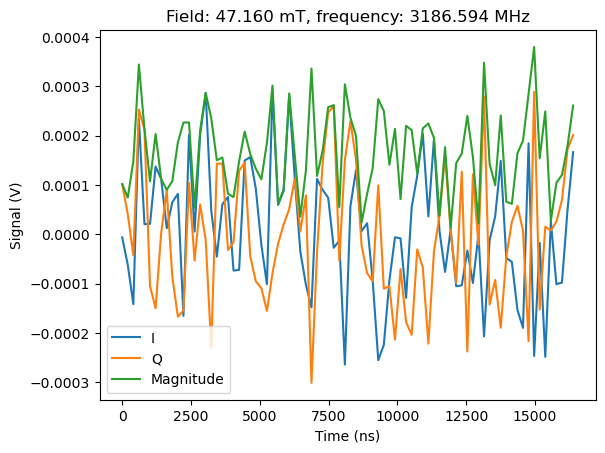

Starting at field 47.17mT
Setting field to 47.15mT
field: 47.150418045018434mT
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


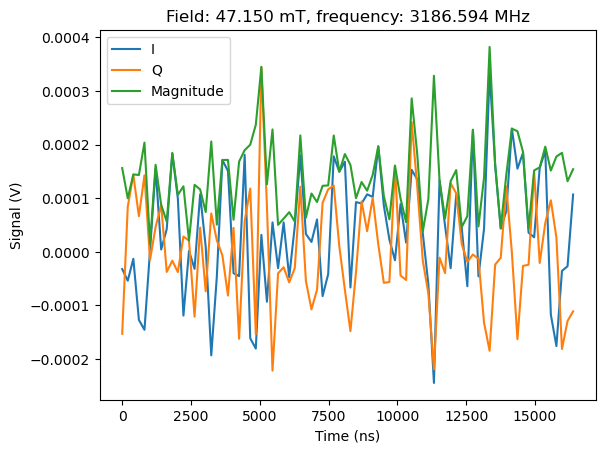

Starting at field 47.15mT
Setting field to 47.14mT
field: 47.13078467477494mT
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


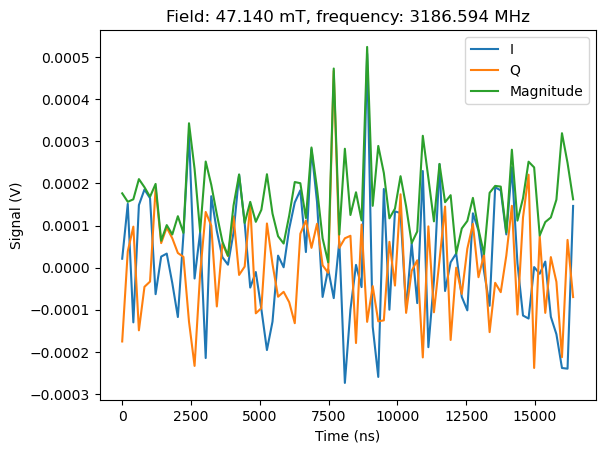

Starting at field 47.14mT
Setting field to 47.13mT
field: 47.13027424745161mT
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


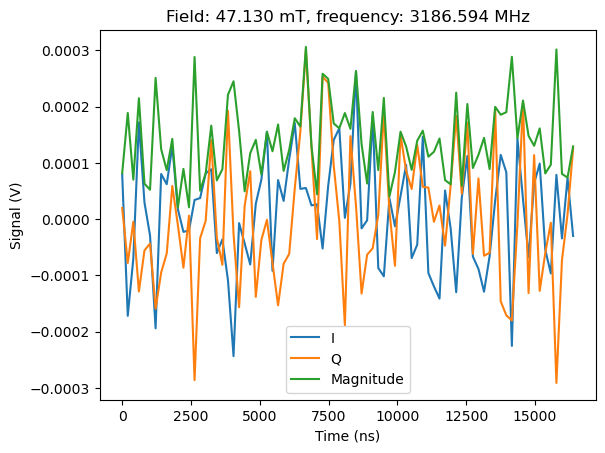

Starting at field 47.13mT
Setting field to 47.12mT
field: 47.118582723273846mT
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


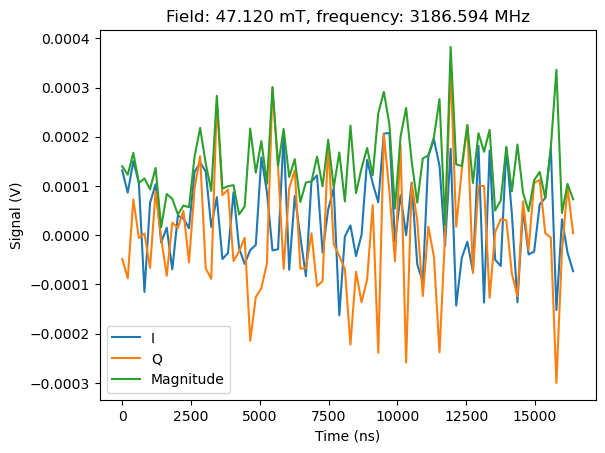

Starting at field 47.11mT
Setting field to 47.11mT
field: 47.10744062438544mT
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


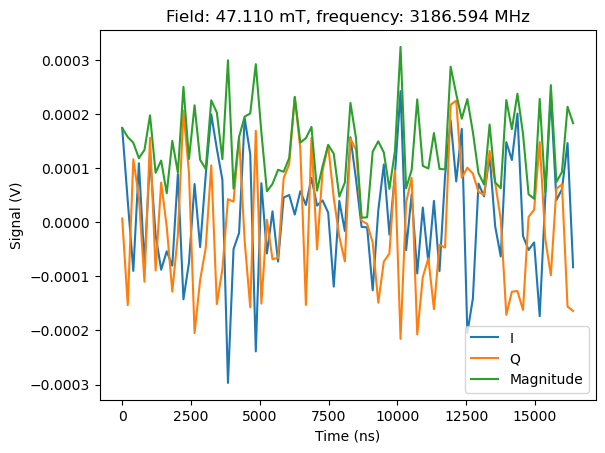

Starting at field 47.11mT
Setting field to 47.10mT
field: 47.10189104802481mT
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


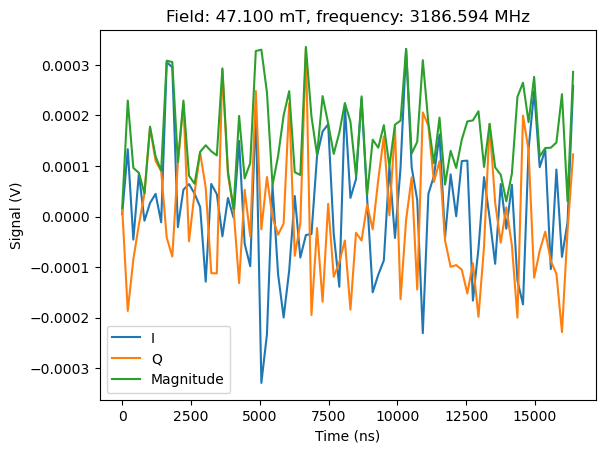

Starting at field 47.10mT
Setting field to 47.09mT
field: 47.08778242994673mT
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


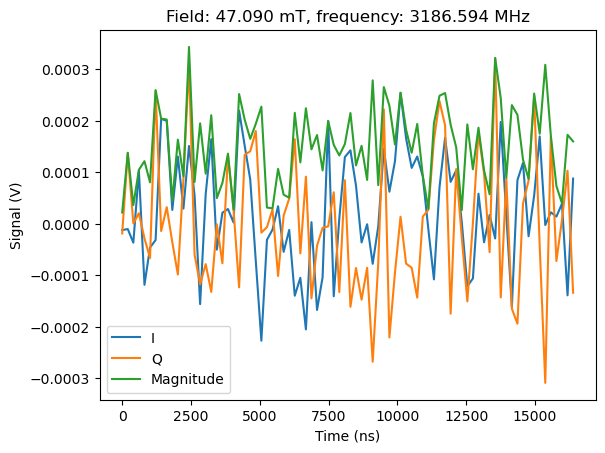

Starting at field 47.09mT
Setting field to 47.08mT
field: 47.08312711173718mT
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


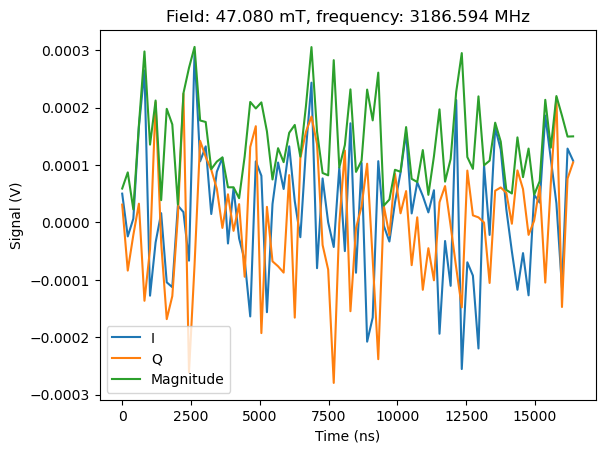

Starting at field 47.08mT
Setting field to 47.07mT
field: 47.069533283643246mT
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


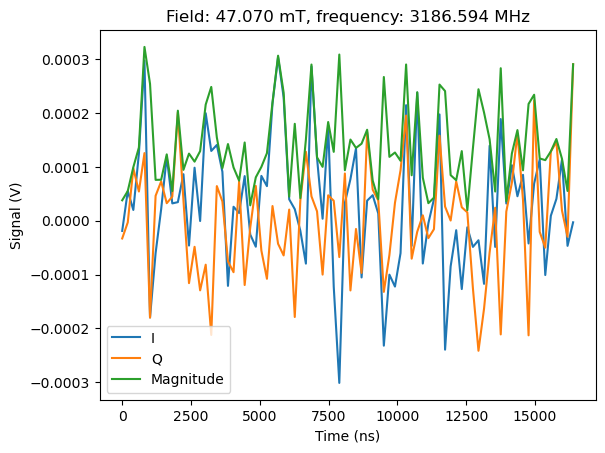

Starting at field 47.07mT
Setting field to 47.06mT
field: 47.0637850550718mT
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


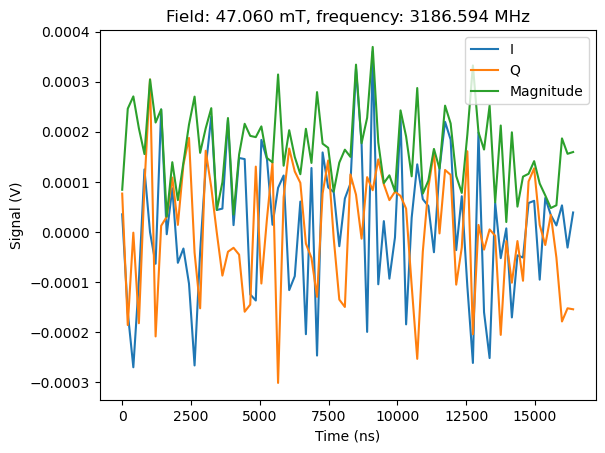

Starting at field 47.06mT
Setting field to 47.05mT
field: 47.055343118608754mT
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


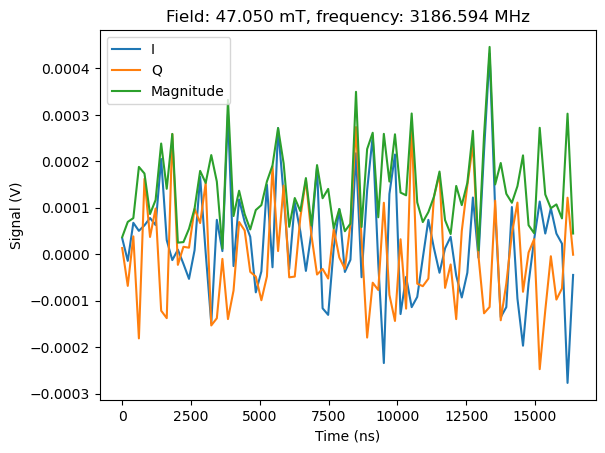

Starting at field 47.05mT
Setting field to 47.04mT
field: 47.03718966530632mT
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


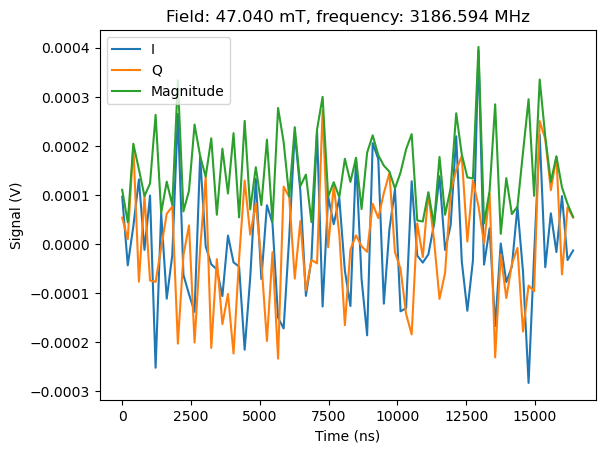

Starting at field 47.04mT
Setting field to 47.03mT
field: 47.03071739235965mT
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


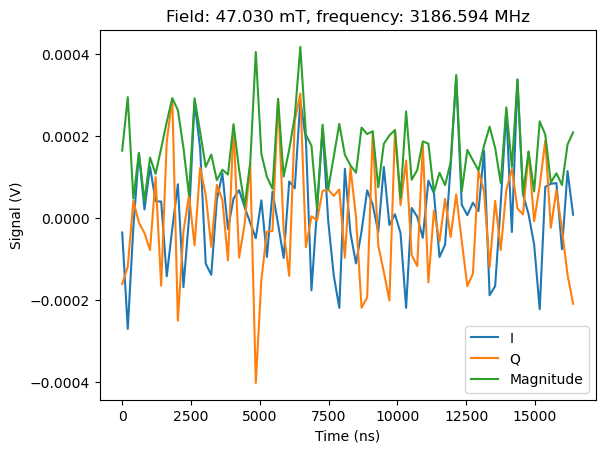

Starting at field 47.03mT
Setting field to 47.02mT
field: 47.01749486956956mT
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


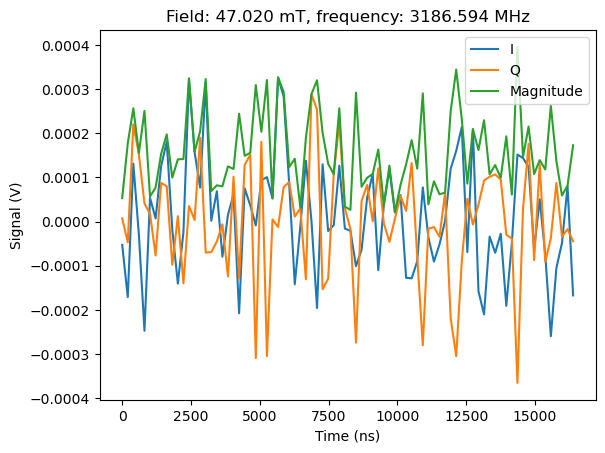

Starting at field 47.01mT
Setting field to 47.01mT
field: 47.00940013422848mT
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


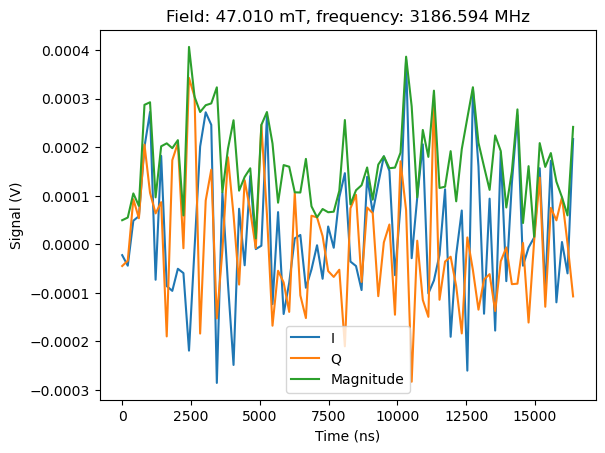

Starting at field 47.01mT
Setting field to 47.00mT
field: 47.00157548944503mT
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


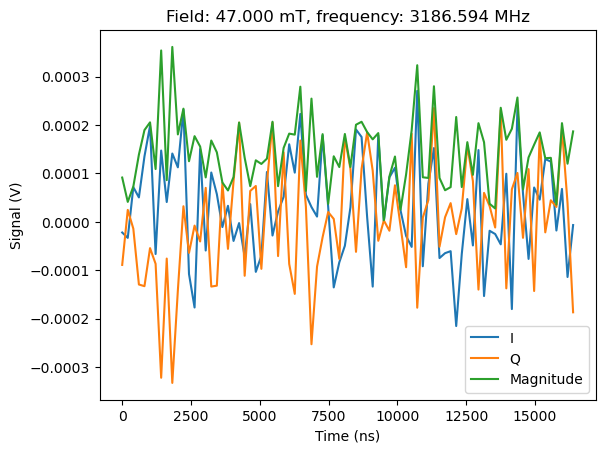

In [179]:
data_list = []
data_int_list = []
recorded_fields = []
res_freq_list = []
Q_list = []
attenuation = 10
amp = 1
len_pi_over_2 = int(8e3)
len_pi = 2*len_pi_over_2
tau = int(40e3)
rec_del = int(10e9)
avg_nb = 5
dummy_nb = 5
steps=None
ctp=None
integ_len = 16000
acq_pos = -5000
ph_cy = 1 
attenuation = 10


qrm_rf.out0_att(int(attenuation))

measure.set_magnetic_field(magnet, fields[0]+2, magnet_type="AM1430", sleep_time=None, options=magnet_options)


for field in fields:
    
    recorded_field = measure.set_magnetic_field(magnet, field, magnet_type="AM1430", sleep_time=None, options=magnet_options)
    # recorded_field = measure.current_to_field(magnet.ch1.source_current()*1e3, magnet_type="AM1430") # accurate field measurement
    recorded_fields.append(recorded_field)
    print(f'field: {recorded_field}mT')
    
    sequence = setup_hahnecho(amp, len_pi_over_2, len_pi, tau, rec_del, avg_nb=avg_nb, acq_pos=acq_pos, steps=None, ctp=None, dummy_nb=dummy_nb)
    #res_freq, Q = find_resonance_and_quality_factor(fr_guess=3186.7e6, f_start=-4e6, f_stop=4e6, f_npts=25, attenuation=10, ringdown_length=120e-9, pulse_amplitude=0.51, pulse_length=500, rec_del=int(20e3), avg_nb=int(10e2), plot_all=False, plot=True)
    #print(f'Resonance frequency = {round(res_freq/1e6, 3)}MHz, Q = {Q}')
    #res_freq_list.append(res_freq)
    #Q_list.append(Q)
    
    time.sleep(rec_del/1e9)
    
    qblox_esr.qrm_rf_awg(qrm_rf, lo_freq=freq_pulse-nco_f, nco_freq=nco_f, in0_att=0, out0_att=attenuation)
    qrm_rf.sequencer0.nco_prop_delay_comp_en(True)
    
    qblox_esr.config_acq(qrm_rf, integ_len=integ_len)
    qrm_rf.sequencer0.sequence(sequence) 
    qrm_rf.arm_sequencer(0)
    qrm_rf.start_sequencer()
    data = get_data()
    data_int = get_data_int()
    
    data_list.append(data)
    data_int_list.append(data_int)
    result_on_res = echo_data_treatment(data, 0, None, nco_f, tres=1e-9,
                                      baseline=True, baseline_start=-3000, baseline_stop=-1,
                                      downconvert=True,
                                      filt=True, filt_opt={'bandwidth':5e6, 'centre':0e6},
                                      ph_corr=True,
                                      plot=False,
                                      plot_dem_filt=False)
    plt.show()
    plt.plot(result_on_res[0], np.real(result_on_res[1]), label='I')
    plt.plot(result_on_res[0], np.imag(result_on_res[1]), label='Q')
    plt.plot(result_on_res[0], np.abs(result_on_res[1]), label='Magnitude')
    #plt.xlim(0, 10000)
    plt.legend()
    plt.xlabel('Time (ns)')
    plt.ylabel('Signal (V)')
    plt.title(f'Field: {field:.3f} mT, frequency: {freq_pulse/1e6:.3f} MHz')
    plt.show()


In [27]:
filename = "C:/Users/Administrator/Documents/Gargi/EDFS/EDFS_data_10012026_9.8mT_xaxis.h5"
comments = 'EDFS_echo_test'
data2save = {
    'raw signal intensity (2D) (a.u.)': data_list,
    'integrated signal intensity (a.u.)': data_int_list,
    'measured magnetic field (mT)': recorded_fields,
    'resonator frequency (Hz)': res_freq_list,
}

metadata = {
    'pulse amplitude': amp,
    'recycling delay (ns)': rec_del,
    'integration time (ns)': integ_len,
    'acquisition position (ns)': acq_pos,
    'length of pi pulse (ns)': len_pi, 
    'length of pi over 2 pulse (ns)': len_pi_over_2,
    'tau (ns)': tau,
    'NCO frequency (Hz)': nco_f,
    'recycling delay (ns)': rec_del,
    'number of averages': avg_nb,
    'number of dummy points': dummy_nb,
    'attenuation on qblox output (dB)': attenuation,
    'phase cycling': ph_cy,
}
process.save_h5(filename, data2save, metadata, comments=comments)

Data saved successfully to C:/Users/Administrator/Documents/Gargi/EDFS/EDFS_data_10012026_9.8mT_xaxis.h5


### Open h5 file

In [187]:
data, metadata, comments = process.open_h5('C:/Users/Administrator/Documents/Gargi/EDFS/EDFS_data_09012026_10.274mT_xaxis.h5')
data_int_list = data['integrated signal intensity (a.u.)']
recorded_fields = data['measured magnetic field (mT)']
res_freq_list = data['resonator frequency (Hz)']

In [188]:
import matplotlib.pyplot as plt
import numpy as np

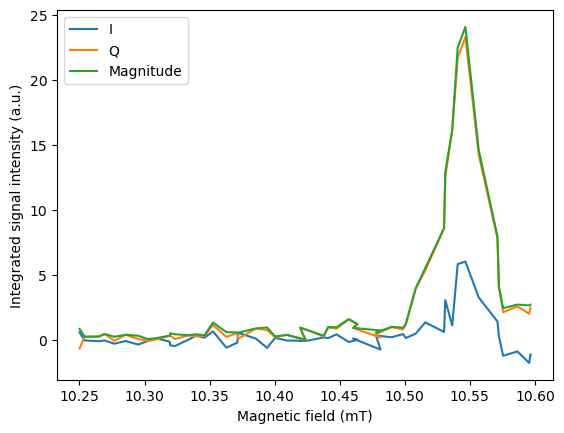

In [28]:
plt.plot(recorded_fields, np.real(data_int_list), label='I')
plt.plot(recorded_fields, np.imag(data_int_list), label='Q')
plt.plot(recorded_fields, np.abs(data_int_list), label='Magnitude')
plt.legend()
plt.xlabel('Magnetic field (mT)')
plt.ylabel('Integrated signal intensity (a.u.)')
plt.show()

In [ ]:
print("len(recorded_fields):", len(recorded_fields))
print("len(data_int_list):", len(data_int_list))
print("len(res_freq_list):", len(res_freq_list))

print("recorded_fields shape:", np.shape(recorded_fields))
print("data_int_list shape:", np.shape(data_int_list))
print("res_freq_list shape:", np.shape(res_freq_list))


ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

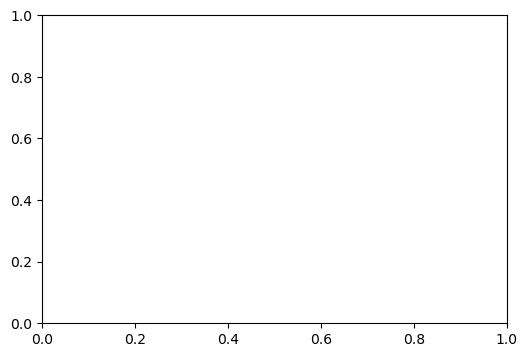

In [190]:

fields_mT = recorded_fields
res_freq_MHz = [f/1e6 for f in res_freq_list]

plt.figure(figsize=(6,4))
#plt.plot(fields_mT, res_freq_MHz, marker='o')
plt.plot(fields, res_freq_MHz, marker='o')
plt.xlabel("Magnetic field (mT)")
plt.ylabel("Resonance frequency (MHz)")
plt.title("Resonance frequency vs magnetic field")
plt.grid(False)
plt.tight_layout()
plt.show()


9.857815566341257


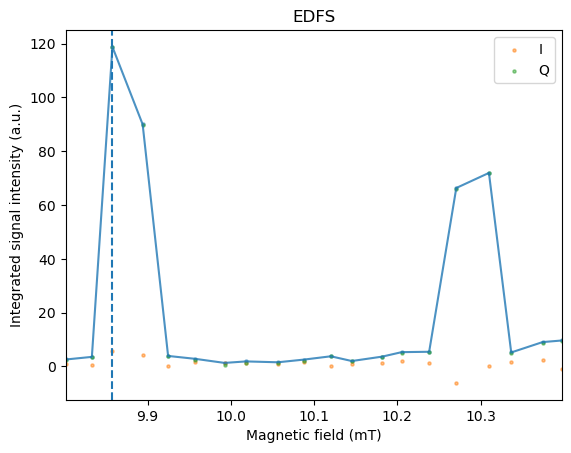

ValueError: x and y must be the same size

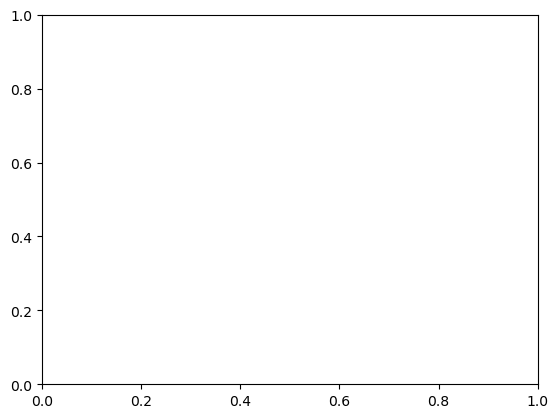

In [191]:
plt.scatter(recorded_fields, np.abs(data_int_list), s=5, alpha=0.5)
plt.scatter(recorded_fields, np.real(data_int_list), label='I', s=5, alpha=0.5)
plt.scatter(recorded_fields, np.imag(data_int_list), label='Q', s=5, alpha=0.5)
plt.plot(recorded_fields, np.abs(data_int_list), alpha=0.8)
plt.xlabel('Magnetic field (mT)')
plt.ylabel('Integrated signal intensity (a.u.)')
plt.title('EDFS')
idx = np.argmax(np.abs(data_int_list))
plt.axvline(x=recorded_fields[idx], linestyle='--')
print(recorded_fields[idx])
plt.legend()
plt.xlim(recorded_fields[-1], recorded_fields[0])
plt.show()

plt.scatter(recorded_fields, np.array(res_freq_list)/1e6, s=2, alpha=1)
plt.plot(recorded_fields, np.array(res_freq_list)/1e6, alpha=1)
plt.xlim(recorded_fields[-1], recorded_fields[0])
plt.xlabel('Magnetic field (mT)')
plt.ylabel('Resonator frequency (MHz)')
plt.show()

## Sweeping with tau

In [105]:
data_list = []
data_int_list = []
tau_list = []

res_freq_list = []
Q_list = []

attenuation = 10
amp = 1
len_pi_over_2 = int(8e3)
len_pi = 2*len_pi_over_2
tau = int(40e3)
rec_del = int(10e9)
avg_nb = 5
dummy_nb = 5
steps=None
ctp=None
integ_len = 16000
acq_pos = -5000
ph_cy = 1 
attenuation = 10

qrm_rf.out0_att(int(attenuation))

B0_mT = 10.55
recorded_field = measure.set_magnetic_field(
    magnet, B0_mT, magnet_type="AM1430", sleep_time=None, options=magnet_options
)
print(f"Fixed field: {recorded_field} mT")


Starting at field 10.54mT
Setting field to 10.55mT
Fixed field: 10.556146081312061 mT


In [200]:
res_freq, Q = find_resonance_and_quality_factor(
    fr_guess=3186e6, f_start=-4e6, f_stop=4e6, f_npts=25,
    attenuation=10, ringdown_length=120e-9,
    pulse_amplitude=1, pulse_length=500,
    rec_del=int(1e4), avg_nb=int(10e2),
    plot_all=False, plot=True
)
print(f"Resonance frequency = {res_freq/1e6:.3f} MHz, Q = {Q}")
freq_pulse = res_freq     


NameError: name 'find_resonance_and_quality_factor' is not defined

### Sweeping tau for T2 measurements

In [106]:
tau_vals = np.logspace(np.log10(40e3), np.log10(15000e3), 41).astype(int)

### new acquire tau sweep

In [107]:
for tau in tau_vals:
    print(f"tau = {tau} ns ({tau*1e-3:.2f} µs)")

    sequence = setup_hahnecho(
        amp, len_pi_over_2, len_pi,
        tau, rec_del,
        avg_nb=avg_nb, acq_pos=acq_pos,
        steps=None, ctp=None, dummy_nb=dummy_nb
    )
    # res_freq, Q = find_resonance_and_quality_factor(fr_guess=3185.747e6, f_start=-4e6, f_stop=4e6, f_npts=25, attenuation=10, ringdown_length=120e-9, pulse_amplitude=0.51, pulse_length=500, rec_del=int(20e3), avg_nb=int(10e2), plot_all=False, plot=True)
    # print(f'Resonance frequency = {round(res_freq/1e6, 3)}MHz, Q = {Q}')
    # res_freq_list.append(res_freq)
    # Q_list.append(Q)
    
    time.sleep(rec_del/1e9)
    qblox_esr.qrm_rf_awg(qrm_rf, lo_freq=freq_pulse-nco_f, nco_freq=nco_f, in0_att=0, out0_att=int(attenuation))
    qrm_rf.sequencer0.nco_prop_delay_comp_en(True)

    qblox_esr.config_acq(qrm_rf, integ_len=300)
    qrm_rf.sequencer0.sequence(sequence) 
    qrm_rf.arm_sequencer(0)
    qrm_rf.start_sequencer()
    data = get_data()
    data_int = get_data_int()
    result_on_res = echo_data_treatment(data_int, None, None, nco_f, tres=300e-9,
                                      baseline=True, baseline_start=-300, baseline_stop=-1,
                                      downconvert=True,
                                      filt=True, filt_opt={'bandwidth':5e6, 'centre':0e6},
                                      ph_corr=True,
                                      plot=False,
                                      plot_dem_filt=False)


    t_ns, sig = result_on_res
    plt.figure()
    plt.plot(t_ns, np.real(sig), label='I')
    plt.plot(t_ns, np.imag(sig), label='Q')
    plt.plot(t_ns, np.abs(sig), label='|Magnitude|')
    plt.xlabel('Time (ns)')
    plt.ylabel('Signal (V)')
    plt.title(f'Field: {recorded_field:.3f} mT, tau = {tau*1e-3:.2f} µs')
    plt.legend()
    plt.show()



tau = 40000 ns (40.00 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


C:\ProgramData\miniconda3\envs\qcodes-res\lib\site-packages\numpy\lib\_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\ProgramData\miniconda3\envs\qcodes-res\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: Invalid number of FFT data points (0) specified.

tau = 40000 ns (40.00 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


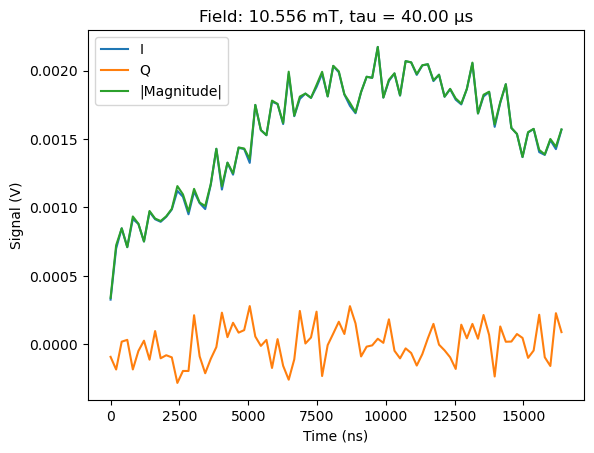

tau = 46388 ns (46.39 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


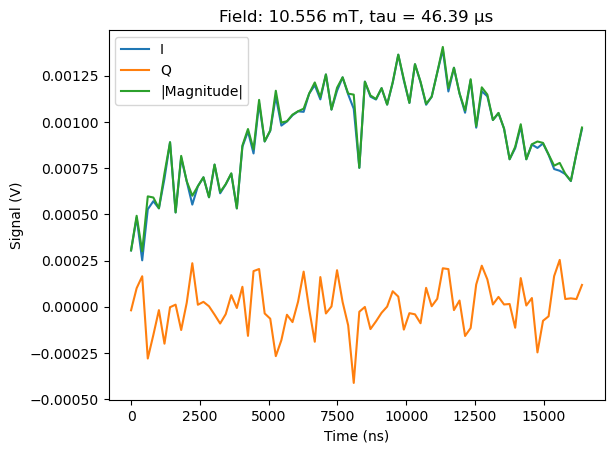

tau = 53797 ns (53.80 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


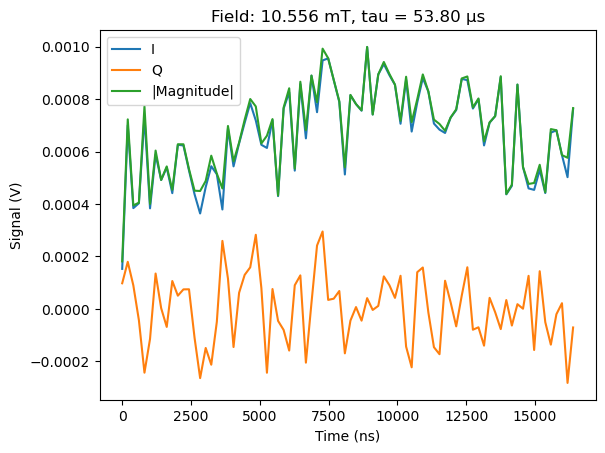

tau = 62389 ns (62.39 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


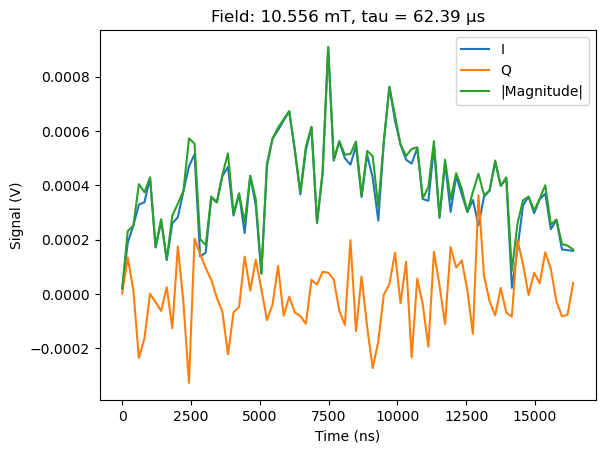

tau = 72354 ns (72.35 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


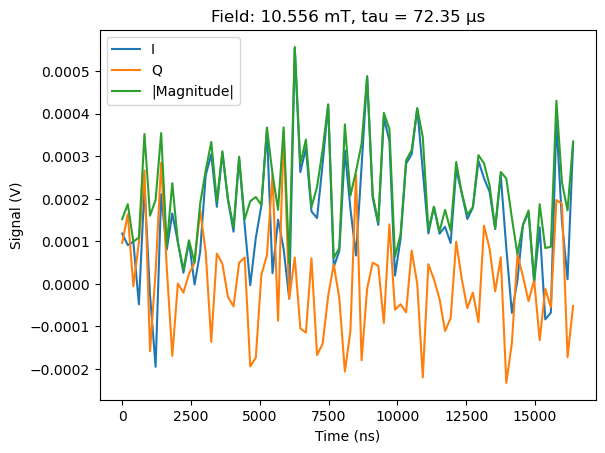

tau = 83910 ns (83.91 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


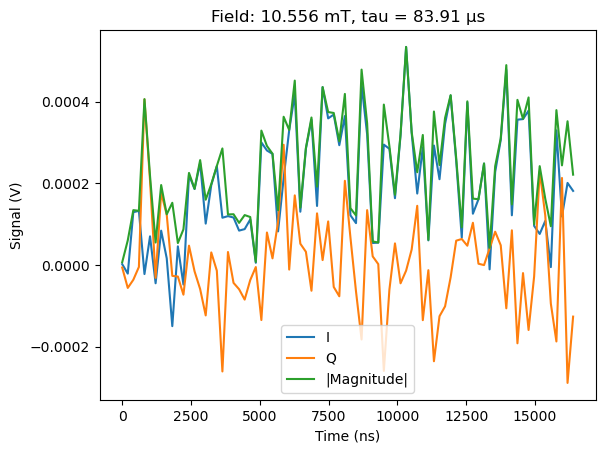

tau = 97311 ns (97.31 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


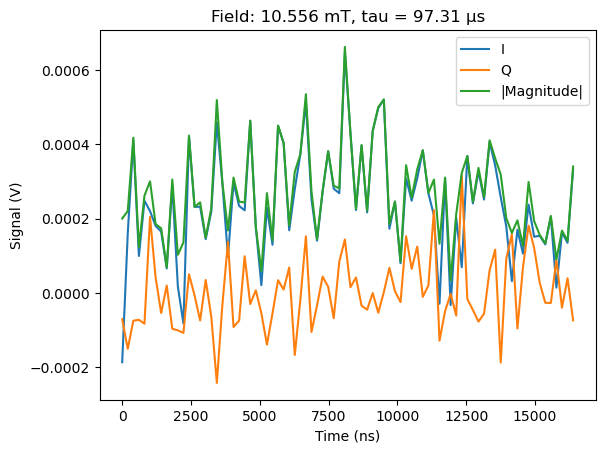

tau = 112853 ns (112.85 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


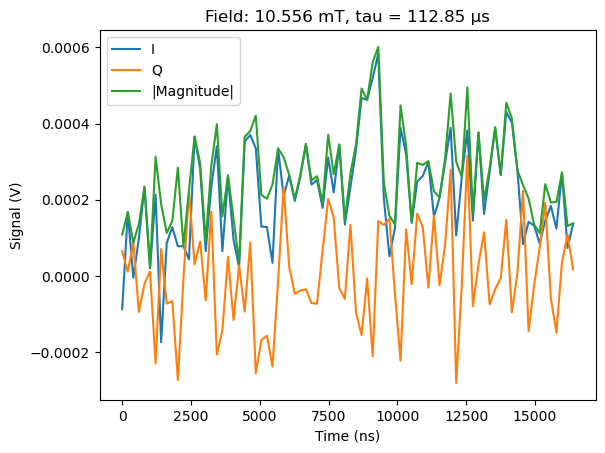

tau = 130877 ns (130.88 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


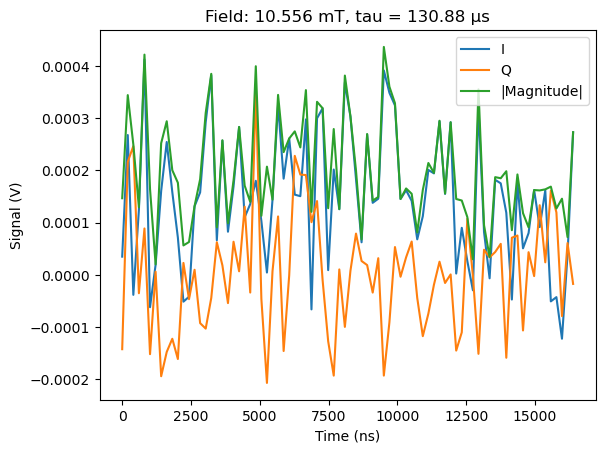

tau = 151780 ns (151.78 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


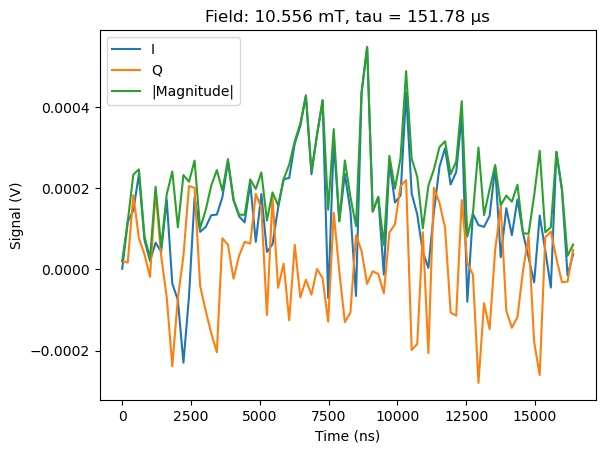

tau = 176022 ns (176.02 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


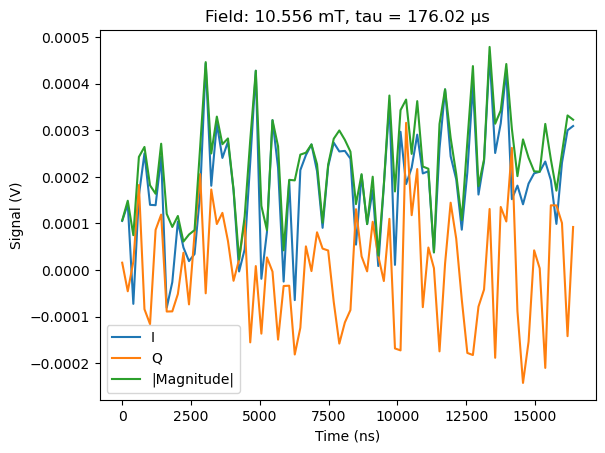

tau = 204135 ns (204.13 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


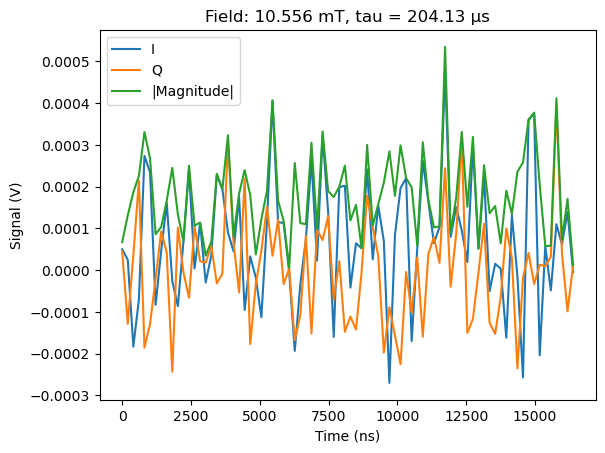

tau = 236738 ns (236.74 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


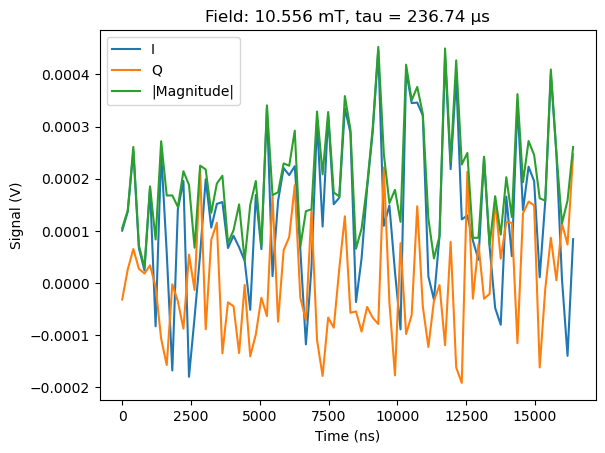

tau = 274549 ns (274.55 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


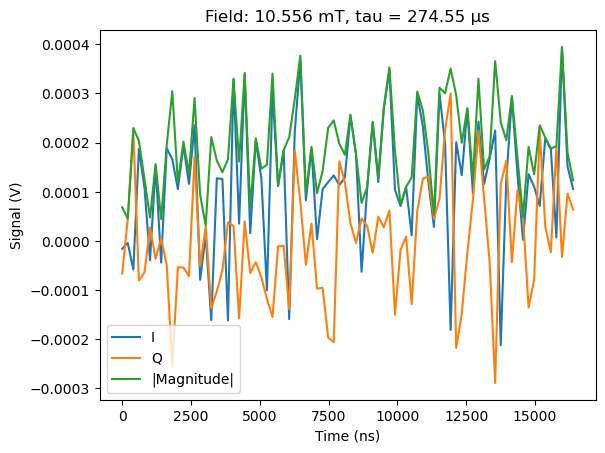

tau = 318398 ns (318.40 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


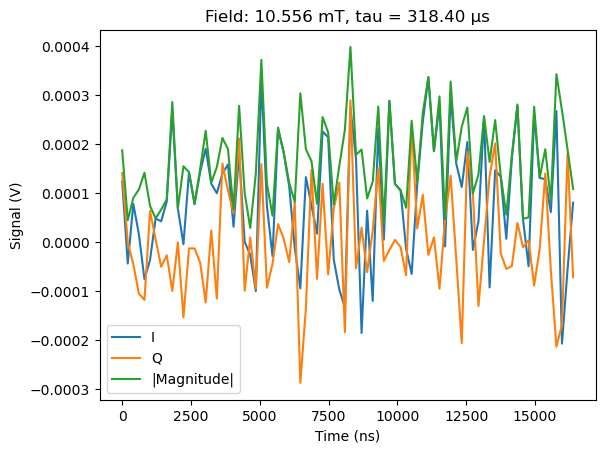

tau = 369251 ns (369.25 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


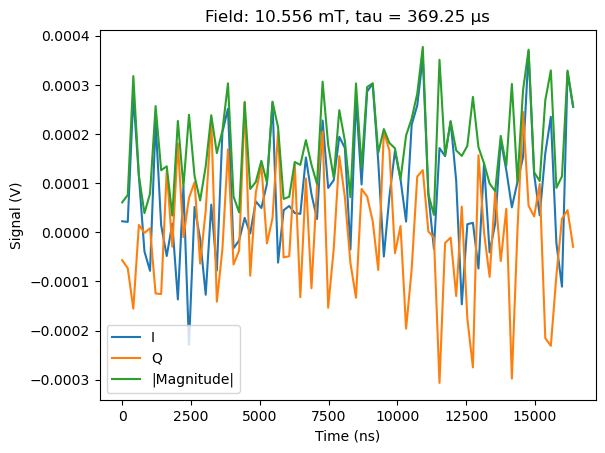

tau = 428225 ns (428.23 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


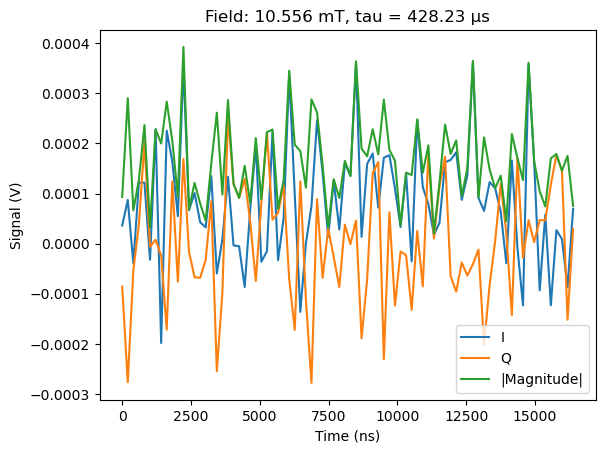

tau = 496618 ns (496.62 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


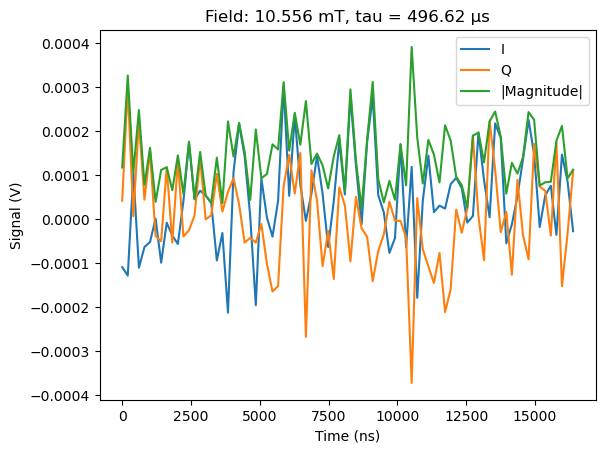

tau = 575935 ns (575.94 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


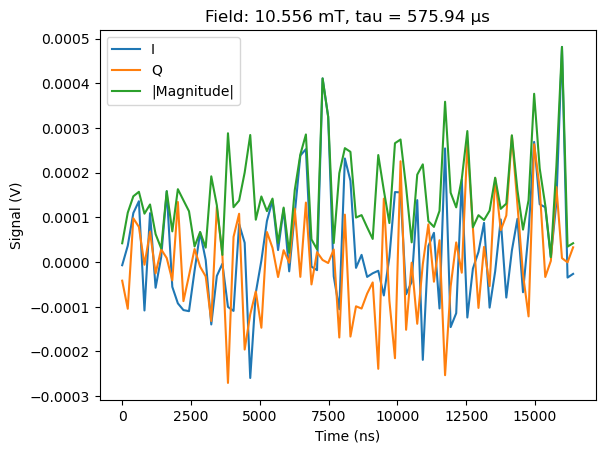

tau = 667920 ns (667.92 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


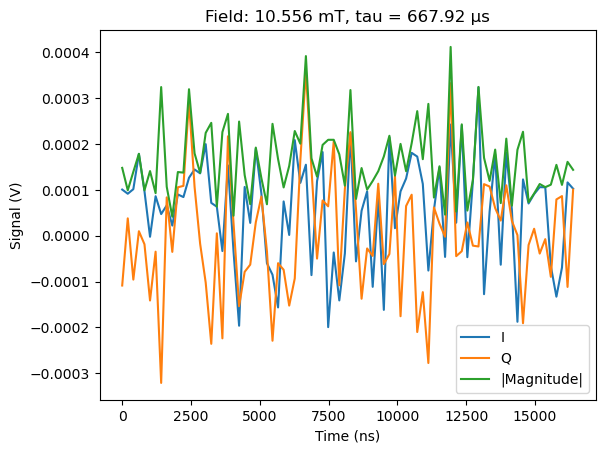

tau = 774596 ns (774.60 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


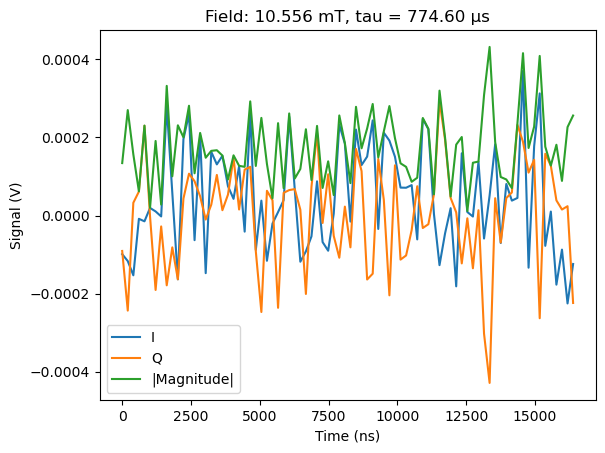

tau = 898310 ns (898.31 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


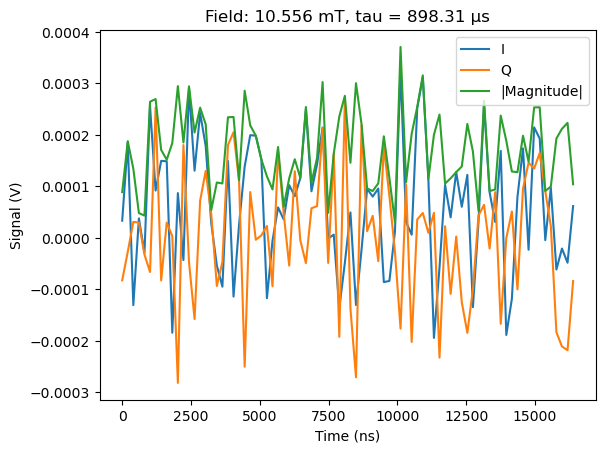

tau = 1041782 ns (1041.78 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


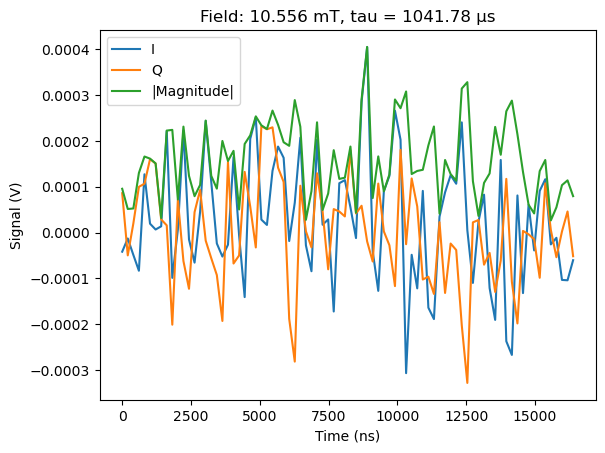

tau = 1208169 ns (1208.17 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


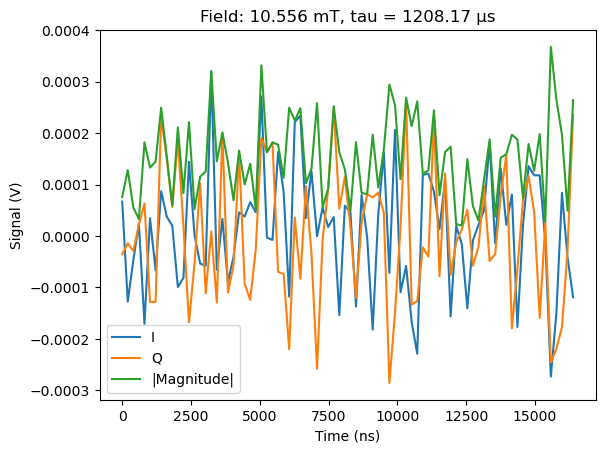

tau = 1401131 ns (1401.13 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


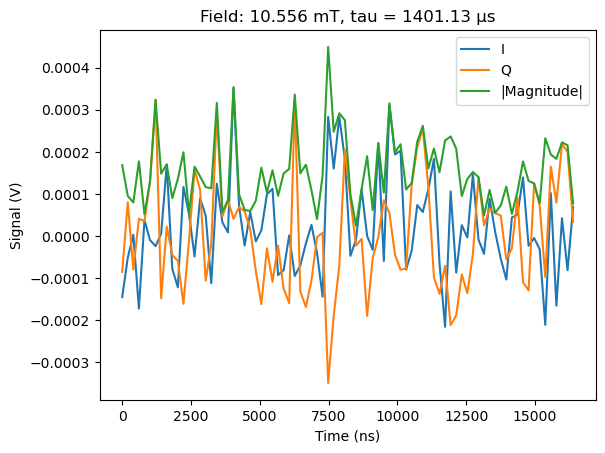

tau = 1624910 ns (1624.91 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


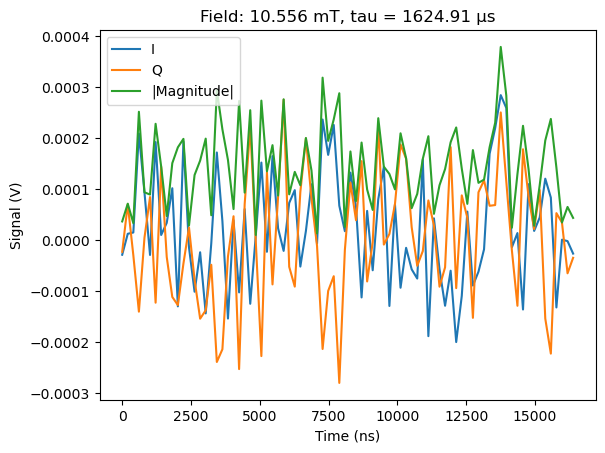

tau = 1884431 ns (1884.43 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


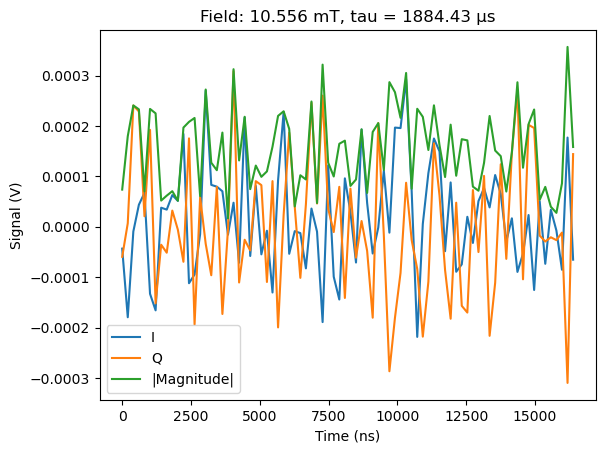

tau = 2185400 ns (2185.40 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


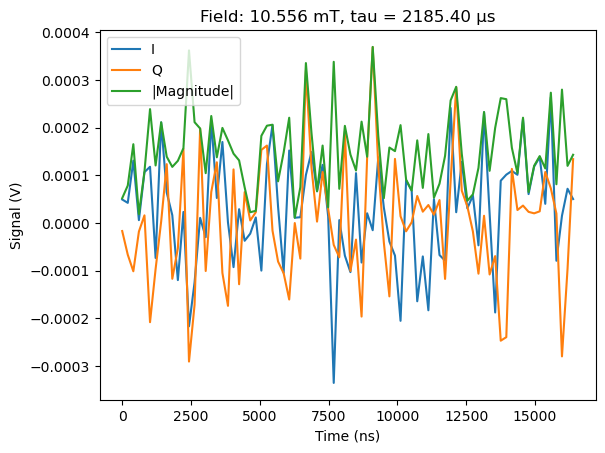

tau = 2534439 ns (2534.44 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


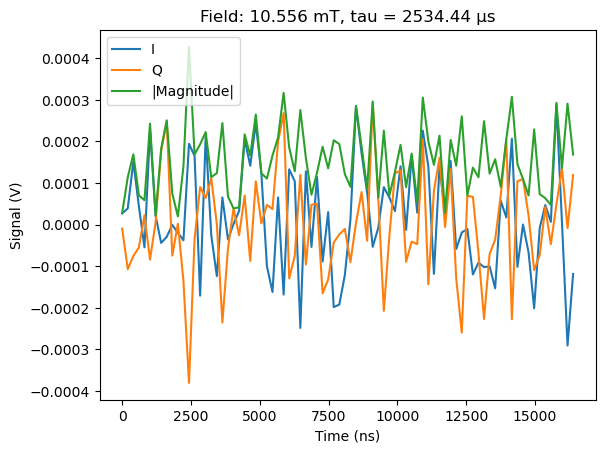

tau = 2939223 ns (2939.22 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


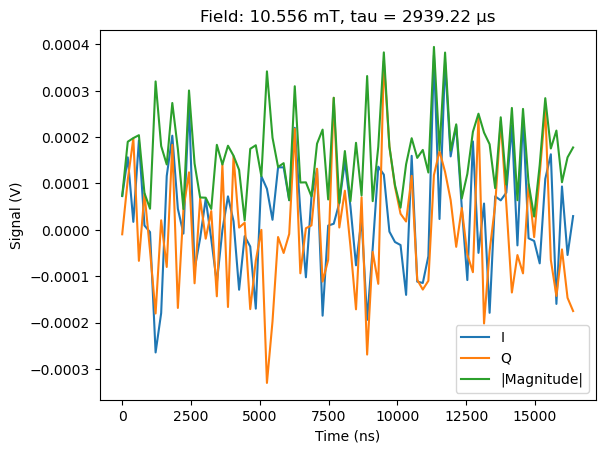

tau = 3408658 ns (3408.66 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


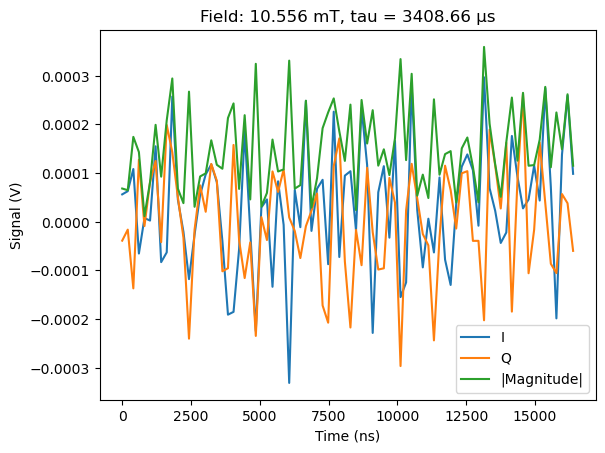

tau = 3953067 ns (3953.07 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


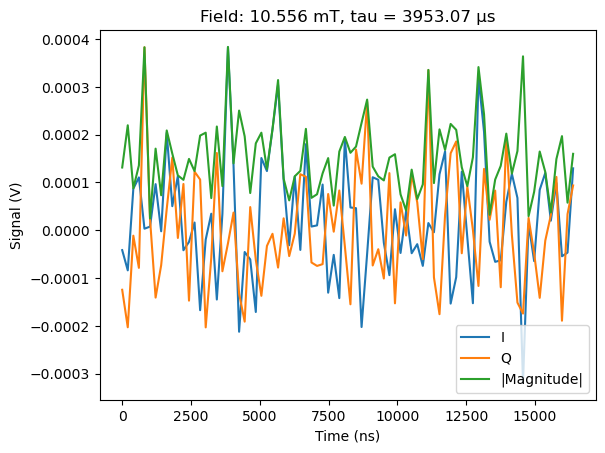

tau = 4584426 ns (4584.43 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


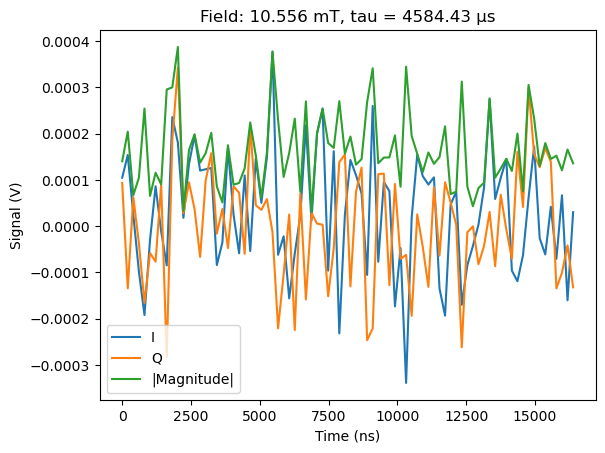

tau = 5316622 ns (5316.62 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


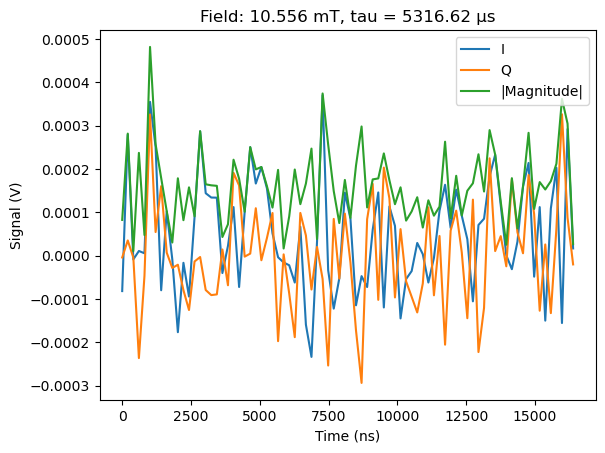

tau = 6165759 ns (6165.76 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


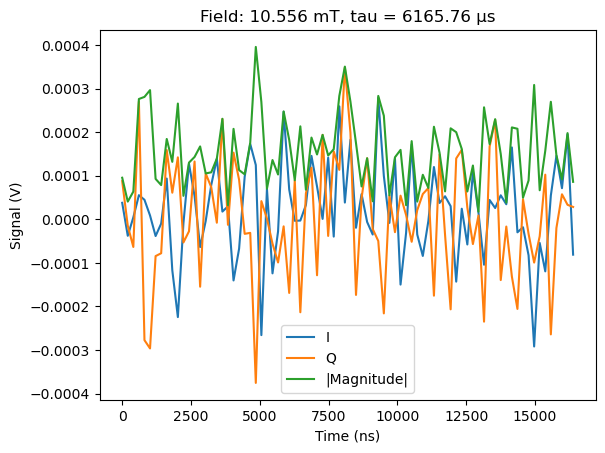

tau = 7150515 ns (7150.52 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


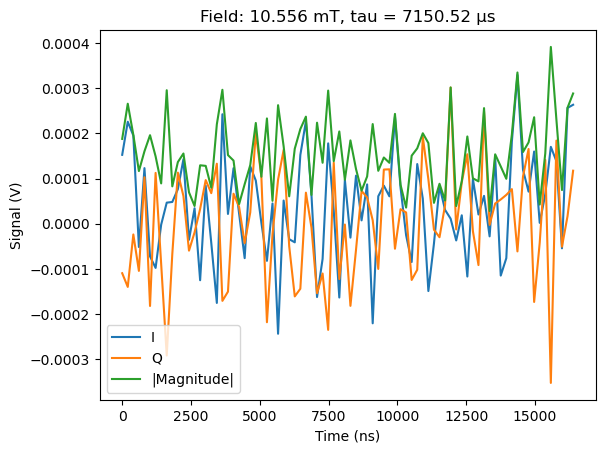

tau = 8292550 ns (8292.55 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


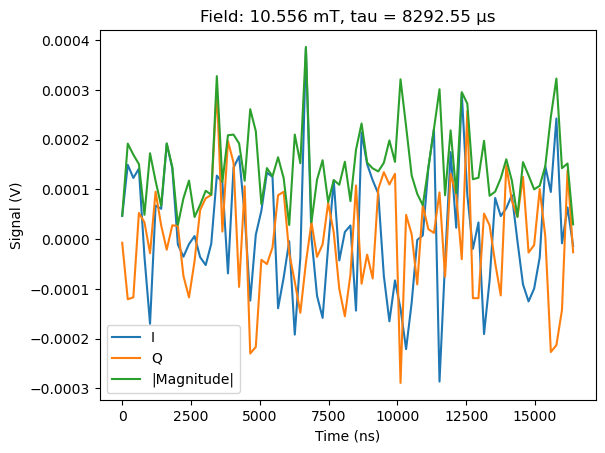

tau = 9616984 ns (9616.98 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


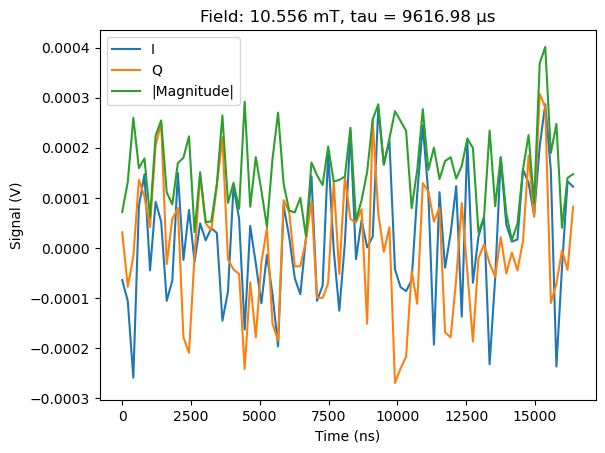

tau = 11152948 ns (11152.95 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


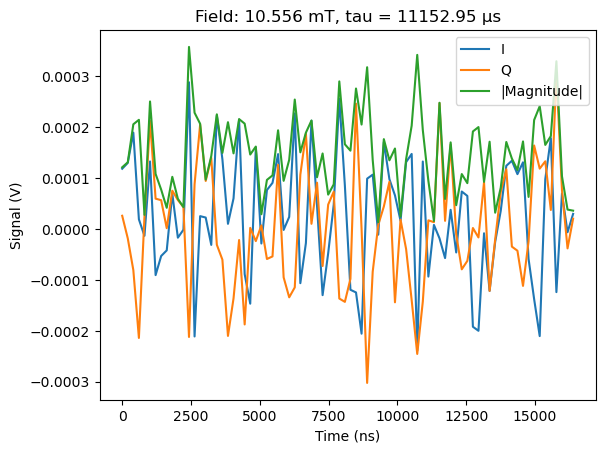

tau = 12934226 ns (12934.23 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


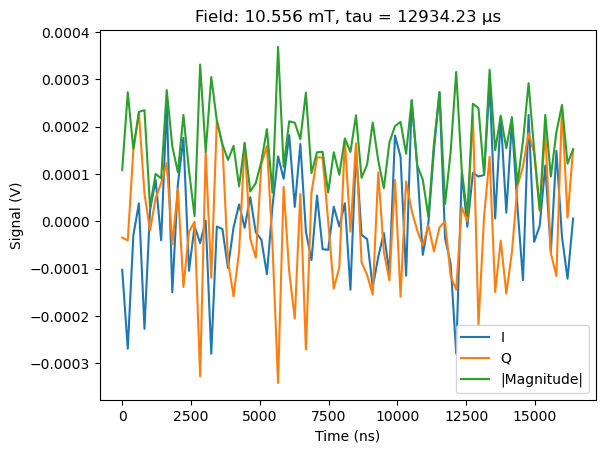

tau = 15000000 ns (15000.00 µs)
Acquisition status:
Status: OKAY, State: RUNNING, Info Flags: NONE, Warning Flags: NONE, Error Flags: NONE, Log: []
Acquisition status:
Status: OKAY, State: STOPPED, Info Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE, Warning Flags: NONE, Error Flags: NONE, Log: []


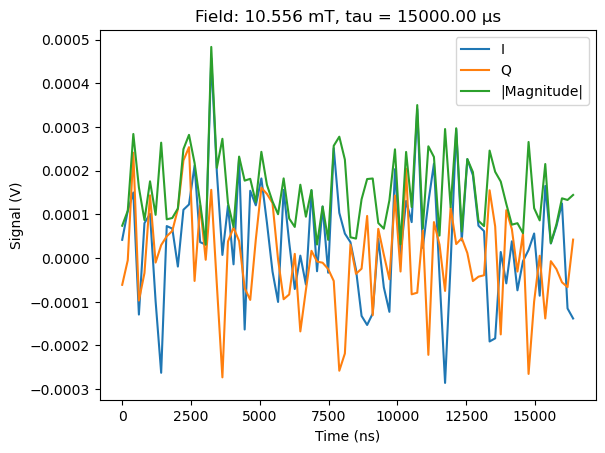

In [108]:

for tau in tau_vals:
    print(f"tau = {tau} ns ({tau*1e-3:.2f} µs)")

    sequence = setup_hahnecho(
        amp, len_pi_over_2, len_pi,
        tau, rec_del,
        avg_nb=avg_nb, acq_pos=acq_pos,
        steps=None, ctp=None, dummy_nb=dummy_nb
    )
    # res_freq, Q = find_resonance_and_quality_factor(fr_guess=3185.747e6, f_start=-4e6, f_stop=4e6, f_npts=25, attenuation=10, ringdown_length=120e-9, pulse_amplitude=0.51, pulse_length=500, rec_del=int(20e3), avg_nb=int(10e2), plot_all=False, plot=True)
    # print(f'Resonance frequency = {round(res_freq/1e6, 3)}MHz, Q = {Q}')
    # res_freq_list.append(res_freq)
    # Q_list.append(Q)
    
    time.sleep(rec_del/1e9)
    qblox_esr.qrm_rf_awg( 
        qrm_rf, lo_freq=freq_pulse - nco_f, nco_freq=nco_f,
        in0_att=0, out0_att=attenuation
    )
    qrm_rf.sequencer0.nco_prop_delay_comp_en(True)

    qblox_esr.config_acq(qrm_rf, integ_len=integ_len)
    qrm_rf.sequencer0.sequence(sequence)
    qrm_rf.arm_sequencer(0)
    qrm_rf.start_sequencer()

    data = get_data()
    data_int = get_data_int()

    data_list.append(data)
    data_int_list.append(data_int)
    tau_list.append(tau)

    result_on_res = echo_data_treatment(
        data, 0, None, nco_f, tres=1e-9,
        baseline=True, baseline_start=-300, baseline_stop=-1,
        downconvert=True,
        filt=True, filt_opt={'bandwidth': 5e6, 'centre': 0e6},
        ph_corr=True,
        plot=False,
        plot_dem_filt=False
    )

    t_ns, sig = result_on_res
    plt.figure()
    plt.plot(t_ns, np.real(sig), label='I')
    plt.plot(t_ns, np.imag(sig), label='Q')
    plt.plot(t_ns, np.abs(sig), label='|Magnitude|')
    plt.xlabel('Time (ns)')
    plt.ylabel('Signal (V)')
    plt.title(f'Field: {recorded_field:.3f} mT, tau = {tau*1e-3:.2f} µs')
    plt.legend()
    plt.show()



In [132]:

filename = "C:/Users/Administrator/Documents/Gargi/Tau_sweep/1101026_10mT_xaxis_0.478msec.h5"
comments = 'EDFS_echo_test'
data2save = {
    'raw signal intensity (2D) (a.u.)': data_list,
    'integrated signal intensity (a.u.)': data_int_list,
    'tau (ns)': tau_list,
    'measured magnetic field (mT)': recorded_fields,   
    'resonator frequency (Hz)': res_freq_list,         
}

metadata = {
    'pulse amplitude': amp,
    'recycling delay (ns)': rec_del,
    'integration time (ns)': integ_len,
    'acquisition position (ns)': acq_pos,
    'length of pi pulse (ns)': len_pi,
    'length of pi over 2 pulse (ns)': len_pi_over_2,
    'NCO frequency (Hz)': nco_f,
    'number of averages': avg_nb,
    'number of dummy points': dummy_nb,
    'attenuation on qblox output (dB)': attenuation,
    'phase cycling': ph_cy,
    'tau sweep values (ns)': tau_vals, 
}

process.save_h5(filename, data2save, metadata, comments=comments)

Data saved successfully to C:/Users/Administrator/Documents/Gargi/Tau_sweep/1101026_10mT_xaxis_0.478msec.h5


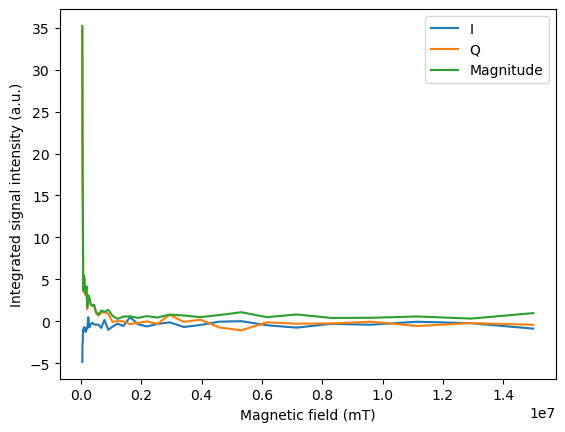

In [111]:
data, metadadata, comments = process.open_h5('C:/Users/Administrator/Documents/Gargi/Tau_sweep/11012026_10.56mT_xaxis.h5')
data_int_list = data['integrated signal intensity (a.u.)']
recorded_fields = data['tau (ns)']
res_freq_list = data['resonator frequency (Hz)']

plt.plot(recorded_fields, np.real(data_int_list), label='I')
plt.plot(recorded_fields, np.imag(data_int_list), label='Q')
plt.plot(recorded_fields, np.abs(data_int_list), label='Magnitude')
plt.legend()
plt.xlabel('Magnetic field (mT)')
plt.ylabel('Integrated signal intensity (a.u.)')
plt.show()

Fit results
A  = 5.781597977216765
T2 = 719.4096135788509 µs


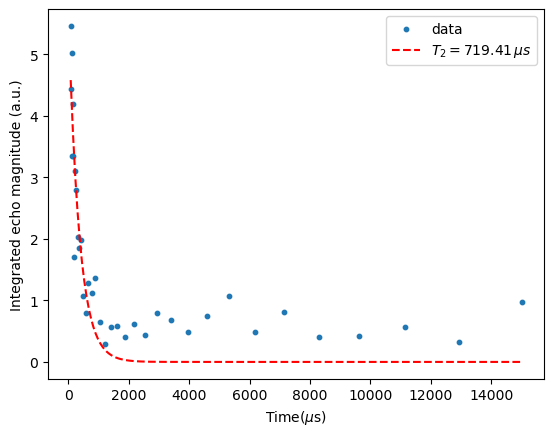

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def T2_model(tau, A, T2):
    return A * np.exp(-2 * tau / T2)

tau_data = np.array(tau_vals[5:], dtype=float) / 1e3   

echo_mag = np.array([np.abs(di).ravel()[0] for di in data_int_list], dtype=float)
y_data = echo_mag[5:]   # match same slice

# Initial guesses
A0  = y_data[0]                         
T2_0 = (tau_data.max() - tau_data.min()) / 2.0

params, covariance = curve_fit(
    T2_model,
    tau_data,
    y_data,
    p0=[A0, T2_0]
)

A_fitted, T2_fitted = params

print("Fit results")
print(f"A  = {A_fitted}")
print(f"T2 = {T2_fitted} µs")

tau_fit = np.linspace(tau_data.min(), tau_data.max(), 200)
plt.scatter(tau_data, y_data, s=10, label="data")
plt.plot(tau_fit, T2_model(tau_fit, A_fitted, T2_fitted),
         'r--', label=rf"$T_2 = {T2_fitted:.2f}\,\mu s$")
plt.xlabel(r"Time($\mu$s)")
plt.ylabel("Integrated echo magnitude (a.u.)")
plt.legend()
plt.show()

## Adding 1sigma uncertainity

Fit results (1σ uncertainties)
A  = 5.782 ± 0.554
T2 = 719.41 ± 115.28 µs


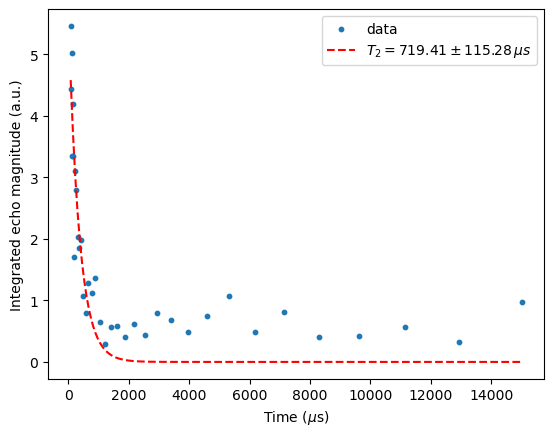

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def T2_model(tau, A, T2):
    return A * np.exp(-2 * tau / T2)

tau_data = np.array(tau_vals[5:], dtype=float) / 1e3  # µs

echo_mag = np.array([np.abs(di).ravel()[0] for di in data_int_list], dtype=float)
y_data = echo_mag[5:]

# Initial guesses
A0  = y_data[0]
T2_0 = (tau_data.max() - tau_data.min()) / 2.0

params, covariance = curve_fit(
    T2_model,
    tau_data,
    y_data,
    p0=[A0, T2_0]
)

A_fitted, T2_fitted = params
perr = np.sqrt(np.diag(covariance))
A_err, T2_err = perr

print("Fit results (1σ uncertainties)")
print(f"A  = {A_fitted:.3f} ± {A_err:.3f}")
print(f"T2 = {T2_fitted:.2f} ± {T2_err:.2f} µs")


tau_fit = np.linspace(tau_data.min(), tau_data.max(), 200)
plt.scatter(tau_data, y_data, s=10, label="data")
plt.plot(
    tau_fit,
    T2_model(tau_fit, A_fitted, T2_fitted),
    'r--',
    label=rf"$T_2 = {T2_fitted:.2f} \pm {T2_err:.2f}\,\mu s$"
)

plt.xlabel(r"Time ($\mu$s)")
plt.ylabel("Integrated echo magnitude (a.u.)")
plt.legend()
plt.show()


Fit results (1σ uncertainties)
A  = 5.362 ± 3.437
T2 = 489.16 ± 281.38 µs
C  = 0.470 ± 0.120


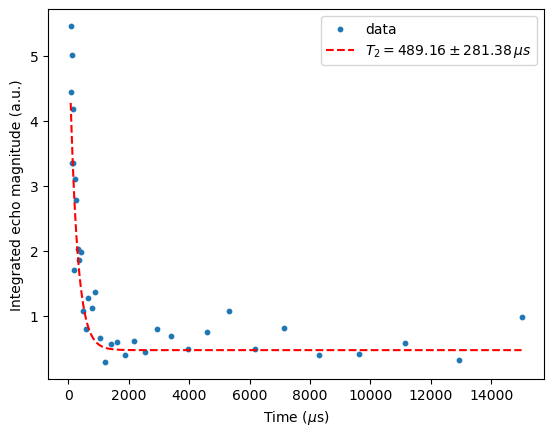

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- Model: exponential + offset (noise floor) ---
def T2_model(tau, A, T2, C):
    return A * np.exp(-2 * tau / T2) + C

# Data (µs)
tau_data = np.array(tau_vals[5:], dtype=float) / 1e3
echo_mag = np.array([np.abs(di).ravel()[0] for di in data_int_list], dtype=float)
y_data = echo_mag[5:]

# --- Initial guesses (robust) ---
C0  = np.mean(y_data[-5:])                 # baseline from last points
A0  = max(y_data[0] - C0, 1e-6)            # amplitude above baseline
T2_0 = (tau_data.max() - tau_data.min()) / 3.0

# --- Weights (optional but recommended) ---
# This downweights late-time points where it's mostly noise.
# You can tune the floor (here: 5% of max signal).
sigma = np.maximum(0.05 * np.max(y_data), y_data)

params, covariance = curve_fit(
    T2_model,
    tau_data,
    y_data,
    p0=[A0, T2_0, C0],
    sigma=sigma,
    absolute_sigma=True,
    maxfev=20000
)

A_fitted, T2_fitted, C_fitted = params
perr = np.sqrt(np.diag(covariance))
A_err, T2_err, C_err = perr

print("Fit results (1σ uncertainties)")
print(f"A  = {A_fitted:.3f} ± {A_err:.3f}")
print(f"T2 = {T2_fitted:.2f} ± {T2_err:.2f} µs")
print(f"C  = {C_fitted:.3f} ± {C_err:.3f}")

# Plot
tau_fit = np.linspace(tau_data.min(), tau_data.max(), 400)

plt.scatter(tau_data, y_data, s=10, label="data")
plt.plot(
    tau_fit,
    T2_model(tau_fit, A_fitted, T2_fitted, C_fitted),
    'r--',
    label=rf"$T_2 = {T2_fitted:.2f} \pm {T2_err:.2f}\,\mu s$"
)

plt.xlabel(r"Time ($\mu$s)")
plt.ylabel("Integrated echo magnitude (a.u.)")
plt.legend()
plt.show()


## With baseline correction

Baseline estimate: 0.5332674144806336
A  = 6.082 ± 0.623
T2 = 484.34 ± 68.96 µs


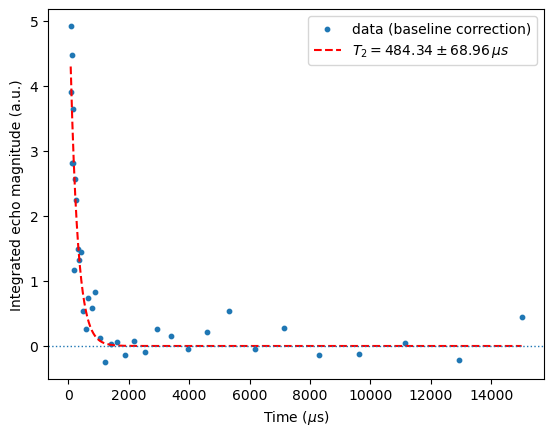

In [135]:


def T2_model(tau, A, T2):
    return A * np.exp(-2 * tau / T2)

tau_data = np.array(tau_vals[5:], dtype=float) / 1e3  # µs
echo_mag = np.array([np.abs(di).ravel()[0] for di in data_int_list], dtype=float)
y_data = echo_mag[5:]


N_tail = 10
B_est = np.median(y_data[-N_tail:])  
y_corr = y_data - B_est


mask = y_corr > 0
tau_fitdata = tau_data[mask]
y_fitdata = y_corr[mask]

A0 = y_fitdata[0]
T2_0 = (tau_fitdata.max() - tau_fitdata.min()) / 2.0

params, cov = curve_fit(T2_model, tau_fitdata, y_fitdata, p0=[A0, T2_0])
A_fitted, T2_fitted = params
A_err, T2_err = np.sqrt(np.diag(cov))

print("Baseline estimate:", B_est)
print(f"A  = {A_fitted:.3f} ± {A_err:.3f}")
print(f"T2 = {T2_fitted:.2f} ± {T2_err:.2f} µs")

tau_plot = np.linspace(tau_data.min(), tau_data.max(), 300)
plt.scatter(tau_data, y_corr, s=10, label="data (baseline correction)")
plt.plot(tau_plot, T2_model(tau_plot, A_fitted, T2_fitted), "r--",
         label=rf"$T_2 = {T2_fitted:.2f}\pm{T2_err:.2f}\,\mu s$")
plt.axhline(0, linestyle=":", linewidth=1)
plt.xlabel(r"Time ($\mu$s)")
plt.ylabel("Integrated echo magnitude (a.u.)")
plt.legend()
plt.show()


In [60]:
print("tau_data shape:", np.shape(tau_data))
print("y_data shape  :", np.shape(y_data))

print("tau_data first/last:", tau_data[0], tau_data[-1])
print("y_data   first/last:", y_data[0], y_data[-1])


tau_data shape: (30,)
y_data shape  : (41,)
tau_data first/last: 41.425 15000.0
y_data   first/last: 4.51323193885698 0.6086164227856293


In [165]:
import pandas as pd

df = pd.DataFrame({
    "tau_us": tau_data,
    "integrated_echo": y_data
})

df.attrs["A_fit"] = A_fitted
df.attrs["T2_us"] = T2_fitted

df.to_csv("C:/Users/Administrator/Documents/Gargi/EDFS/T2_46.2mT_x-axis_baseline_correction.csv", index=False)

Fit results
A  = 10.433220061704908
T2 = 2123.526665945827 µs


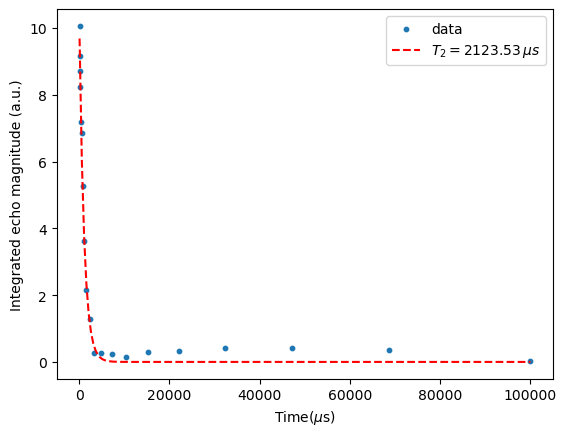

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def T2_model(tau, A, T2):
    return A * np.exp(-2 * tau / T2)

tau_data = np.array(tau_vals[5:], dtype=float) / 1e3   

echo_mag = np.array([np.abs(di).ravel()[0] for di in data_int_list], dtype=float)
y_data = echo_mag[5:]   # match same slice

# Initial guesses
A0  = y_data[0]                         
T2_0 = (tau_data.max() - tau_data.min()) / 2.0

params, covariance = curve_fit(
    T2_model,
    tau_data,
    y_data,
    p0=[A0, T2_0]
)

A_fitted, T2_fitted = params

print("Fit results")
print(f"A  = {A_fitted}")
print(f"T2 = {T2_fitted} µs")

tau_fit = np.linspace(tau_data.min(), tau_data.max(), 200)
plt.scatter(tau_data, y_data, s=10, label="data")
plt.plot(tau_fit, T2_model(tau_fit, A_fitted, T2_fitted),
         'r--', label=rf"$T_2 = {T2_fitted:.2f}\,\mu s$")
plt.xlabel(r"Time($\mu$s)")
plt.ylabel("Integrated echo magnitude (a.u.)")
plt.legend()
plt.show()


A  = 10.43322011061989
T2 = 2123.5266289907668 µs


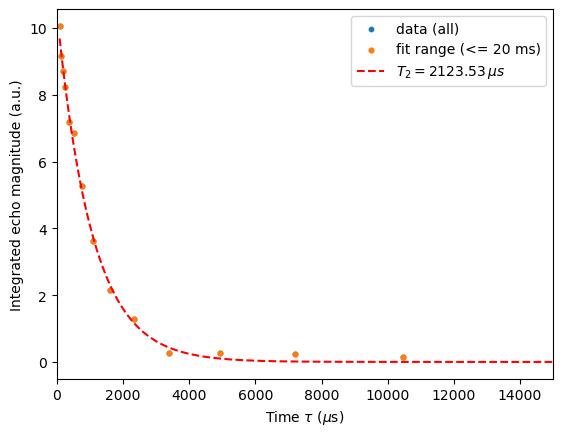

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def T2_model(tau, A, T2):
    return A * np.exp(-2 * tau / T2)

# data
tau_data = np.array(tau_vals[5:], dtype=float) / 1e3   # µs
echo_mag = np.array([np.abs(di).ravel()[0] for di in data_int_list], dtype=float)
y_data = echo_mag[5:]

# keep only tau <= cutoff
cutoff_us = 20000  # 20 ms
mask = tau_data <= cutoff_us
tau_fit_data = tau_data[mask]
y_fit_data   = y_data[mask]

# initial guesses
A0 = y_fit_data[0]
T2_0 = (tau_fit_data.max() - tau_fit_data.min()) / 2.0

params, cov = curve_fit(T2_model, tau_fit_data, y_fit_data, p0=[A0, T2_0])
A_fitted, T2_fitted = params

print(f"A  = {A_fitted}")
print(f"T2 = {T2_fitted} µs")

# plot
tau_line = np.linspace(tau_fit_data.min(), tau_fit_data.max(), 200)
plt.scatter(tau_data, y_data, s=10, label="data (all)")
plt.scatter(tau_fit_data, y_fit_data, s=12, label=f"fit range (<= {cutoff_us/1000:.0f} ms)")
plt.plot(tau_line, T2_model(tau_line, A_fitted, T2_fitted), "r--",
         label=rf"$T_2 = {T2_fitted:.2f}\,\mu s$")
plt.xlabel(r"Time $\tau$ ($\mu$s)")
plt.ylabel("Integrated echo magnitude (a.u.)")
plt.xlim(0, 15000) 
plt.legend()
plt.show()


In [51]:
import pandas as pd

df = pd.DataFrame({
    "tau_us": tau_data,
    "integrated_echo": y_data
})

df.attrs["A_fit"] = A_fitted
df.attrs["T2_us"] = T2_fitted

df.to_csv("C:/Users/Administrator/Documents/Gargi/EDFS/T2_Gargi_04012026.csv", index=False)


In [ ]:
filename = 'D:JB/qblox_ESR/EDFS_tracking_resonator.h5'
comments = 'EDFS to track resonator frequency'
data2save = {

    'raw signal intensity (2D) (a.u.)': data_list,
    'integrated signal intensity (a.u.)': data_int_list,
    'measured magnetic field (mT)': recorded_fields,
    'resonator frequency (Hz)': freqs_pulse,
}

metadata = {
    'pulse amplitude': amp,
    'recycling delay (ns)': rec_del,
    'integration time (ns)': integ_len,
    'acquisition position (ns)': acq_pos,
    'length of pi pulse (ns)': len_pi, 
    'length of pi over 2 pulse (ns)': len_pi_over_2,
    'tau (ns)': tau,
    'NCO frequency (Hz)': nco_f,
    'recycling delay (ns)': rec_del,
    'number of averages': avg_nb,
    'number of dummy points': dummy_nb,
    'attenuation on qblox output (dB)': attenuation,
    'phase cycling': ph_cy,
}
process.save_h5(filename, data2save, metadata, comments=comments)

### EDFS with spec

In [42]:
def find_resonance_and_quality_factor_with_detuning(fr_guess, nco_f, detuning, len_exc_sat=500, len_exc_probe=500, amp_sat=0.0, amp_probe=0.01, t_delay=2000, rec_del=int(0.001e9), avg_nb=100, f_start=-3e6, f_stop=3e6, f_npts=10, start_int=0, end_int=1.5e-6, attenuation=10, plot=False, plot_all=False, max_attempts=10, retries_on_fit_failure=3):
    def exp_decay(t, A, tau, offset):
        """Exponential decay function for fitting the ringdown signal."""
        return A * np.exp(-t / tau) + offset

    def find_resonance_probe_with_retry(fr_guess, max_attempts=10, shift=1e6):
        """Retries finding the resonance frequency with a shifted guess if it fails."""
        attempts = 0
        direction = 1  # Start by increasing frequency
        fr_guess_original = fr_guess  # Store the original guess
        
        while attempts < max_attempts:
            try:
                # Try to find the resonance frequency
                return find_resonance_probe(fr_guess)
            except ValueError as e:
                print(f"Attempt {attempts + 1}: Failed with fr_guess={np.round(fr_guess * 1e-6, 3)} MHz - {str(e)}")
                attempts += 1
                # Alternate between increasing and decreasing fr_guess by 1 MHz
                fr_guess = fr_guess_original + (direction * attempts * shift)
                direction *= -1  # Flip direction for the next iteration
        
        raise RuntimeError(f"Failed to find resonance after {max_attempts} attempts.")

In [43]:
data_list = []
data_int_list = []
recorded_fields = []
freqs_pulse = []
amp = 1
len_pi_over_2 = int(2.5e3)
len_pi = 2*len_pi_over_2
tau = int(10e3)
rec_del = int(1e9)
avg_nb = 10
dummy_nb = 1
steps=None
ctp=None


# qrm_rf.out0_att(int(attenuation))
qrm_rf.out0_att(20)
measure.set_magnetic_field(magnet, 53.1, magnet_type="AM1430", sleep_time=10, options=magnet_options)
# measure.set_magnetic_field(magnet, fields[0]+2, magnet_type="minimagnet", sleep_time=None)

for field in fields:
    
    recorded_field = measure.set_magnetic_field(magnet, field, magnet_type="AM1430", sleep_time=None, options=magnet_options)
    recorded_fields.append(recorded_field)
    
    sequence = setup_hahnecho(amp, len_pi_over_2, len_pi, tau, rec_del, avg_nb=avg_nb, acq_pos=-300, steps=None, ctp=None, dummy_nb=dummy_nb)
    
    freq_pulse = find_resonance_and_quality_factor_with_detuning(fr_guess=freq_pulse, nco_f=nco_f, detuning=0, len_exc_sat=int(1000), len_exc_probe=int(500), amp_sat=float(0), amp_probe=float(0.51), t_delay=int(1000), rec_del=int(0.000002e9), avg_nb=10000, f_start=-4e6, f_stop=4e6, f_npts=15, start_int=0.76e-6, end_int=0.9e-6, attenuation=int(30), plot=False, plot_all=False, max_attempts=10, retries_on_fit_failure=3)
    print(f'Pulses: frequency = {round(freq_pulse/1e6, 3)}MHz')
    freqs_pulse.append(freq_pulse)
    time.sleep(rec_del/1e9)
    
    qblox_esr.qrm_rf_awg(qrm_rf, lo_freq=freq_pulse-nco_f, nco_freq=nco_f, in0_att=0, out0_att=10)
    qrm_rf.sequencer0.nco_prop_delay_comp_en(True)
    
    qblox_esr.config_acq(qrm_rf, integ_len=1000)
    qrm_rf.sequencer0.sequence(sequence) 
    qrm_rf.arm_sequencer(0)
    qrm_rf.start_sequencer()
    data = get_data()
    data_int = get_data_int()
    
    data_list.append(data)
    data_int_list.append(data_int)
    result_on_res = echo_data_treatment(data, 0, 8000, nco_f, tres=1e-9,
                                      baseline=True, baseline_start=-300, baseline_stop=-1,
                                      downconvert=True,
                                      filt=True, filt_opt={'bandwidth':40e6, 'centre':0e6},
                                      ph_corr=False,
                                      plot=False,
                                      plot_dem_filt=False)
    plt.show()
    plt.plot(result_on_res[0], np.real(result_on_res[1]), label='I')
    plt.plot(result_on_res[0], np.imag(result_on_res[1]), label='Q')
    plt.plot(result_on_res[0], np.abs(result_on_res[1]), label='Magnitude')
    plt.xlim(0, 1500)
    plt.legend()
    plt.xlabel('Time (ns)')
    plt.ylabel('Signal (V)')
    plt.title(f'Field: {field:.3f} mT, frequency: {freq_pulse/1e6:.3f} MHz')
    plt.show()

Starting at field 53.50mT
Setting field to 53.10mT
Starting at field 53.11mT
Setting field to 53.50mT


TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

In [180]:
# in T!
ix.field(0)
iy.field(0)
iz.field(0)

In [40]:
ix.zero()
iy.zero()
iz.zero()

In [ ]:
def T2_model(tau, C, T2):
    return C * np.exp(-2*tau/T2)

tau_data = tau_list[5:]/1e3
baseline = np.mean(np.abs(data_int_list[-50:]))
y_data =  np.abs(data_int_list[5:]).ravel() - baseline

# Perform curve fitting
initial_guess = [0, 8]  # Initial guess for C and T2
params, covariance = curve_fit(T2_model, tau_data, y_data, p0=initial_guess)

# Extract the fitted parameters
C_fitted, T2_fitted = params

# Print the results
print(f"Fitted C: {C_fitted}")
print(f"Fitted T2: {T2_fitted}")

# Plot the data and the fitted curve
plt.plot(tau_data, y_data, alpha=0.3)
plt.scatter(tau_data, y_data, s=5)
plt.plot(tau_data, T2_model(tau_data, C_fitted, T2_fitted), linewidth=1,linestyle='--', color='red', label=r'$T_{2}$ = '+str(round(T2_fitted,2))+'us')

plt.xlim(tau_data[0], tau_data[-1])

plt.legend()

plt.xlabel(r'Time between pulses ($\mu$s)')
plt.ylabel('Integrated echo signal (a.u.)')

plt.show()